# 2023-hceres: HAL Data processing

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import unidecode
import json
import re
from typing import Any, Dict, List, Callable, Optional, Union, Pattern
import textwrap
import logging
import time, datetime
import os
import difflib

In [2]:
logging.basicConfig(
    format='[%(asctime)s][%(levelname)-5s][%(funcName)s#%(lineno)s] %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S',
    level=logging.INFO,
)
LOGGER = logging.getLogger(__name__)
LOGGER.info('Logger loaded')

[2023-04-02 17:17:32][INFO ][<module>#7] Logger loaded


# Definitions

## Constants

Define primary constants

* `LAB_STRUCT_ID` : The identifier in HAL of the CES (15080)
* `NON_ALPHA_NUMERIC_REGEX` : Regex to cleanup all non alpha numeric characters
* `JSON_FILENAME` : Extration from HAL API.
* `CURRENT_TIMESTAMP`: The current timestamp of the last run of this notebook (used to retrieve some refenrentials)


In [3]:
LAB_STRUCT_ID = 15080
NON_ALPHA_NUMERIC_REGEX = re.compile('[^a-z0-9_-]', re.IGNORECASE)
JSON_FILENAME = './result.2023-04-02T09-03.json'
CURRENT_TIMESTAMP = datetime.datetime.now().timestamp()

## Functions

In [4]:
# As an alternative, we might extends pandas the official way
# See: https://pandas.pydata.org/docs/development/extending.html#extending-pandas

class DfOps(pd.core.frame.DataFrame):
    
    def __init__(
        self,
        dataframe: pd.core.frame.DataFrame,
        prefix: Optional[str] = None
    ) -> None:
        super().__init__(dataframe)
        self._prefix = (prefix or '').strip('_ ')
    
    def _display(self, df: pd.core.frame.DataFrame) -> 'DfOps':
        import IPython.display as display
        display.display(df)
        return self

    def display(self) -> 'DfOps':
        return self._display(self)
    
    def display_head(self, n=5) -> 'DfOps':
        return self._display(self.head(n=n))
    
    def _target_file(self, filename:str, ext: str) -> str:
        target_file = f'{self._prefix}_{filename}'.strip('_ ')
        target_file = re.compile('[^a-z0-9\.-]+', re.IGNORECASE).sub('_', target_file)
        target_file = re.compile(f'\.{ext}$', re.IGNORECASE).sub('', target_file)
        target_file = f'./exports/{target_file}.{ext.lower()}'
        return target_file
        
    def csv(self, filename: str, index=True, **kwargs) -> 'DfOps':
        target_file = self._target_file(filename=filename, ext='csv')
        to_csv_params = { 'index': index, 'sep': ';', **kwargs }
        LOGGER.info("Export to CSV file: %s (params: %s) (number of rows: %d)", target_file, to_csv_params, len(self))
        self.to_csv(target_file, **to_csv_params)
        return self
    
    def count(self, subset: List[str], column: str, dropna: bool = False) -> 'DfOps':
        return DfOps(self.value_counts(subset=subset, dropna=dropna).to_frame(name=column).reset_index())
    
    def barh(
        self,
        x: str,
        y: str,
        title: str,
        sort_by: List[str] = [],
        plot_params: Dict[str, Any] = None,
        title_params: Dict[str, Any] = None,
        sort_params: Dict[str, Any] = None,
    ) -> 'DfOps':
        sort_by = sort_by or [ y ]
        plot_params = plot_params or {}
        title_params = title_params or {}
        sort_params = sort_params or {}
        
        result_sort_params = {**dict(by=sort_by, ascending=True), **sort_params}
        LOGGER.debug('Sort current dataframe for graph "%s" => sort_params=%s', title, result_sort_params)
        sorted_df = self.sort_values(**result_sort_params)
        
        result_plot_params = {
            **dict(legend=False, xlabel='', ylabel='', figsize=(8, 4), rot=0, fontsize=12), # Default params
            **plot_params, # Override params
            **dict(kind='barh', title=title, x=x) # Forced params
        }
        
        LOGGER.debug('Create barh graph for "%s" => plot_params=%s)', title, result_plot_params)
        p = sorted_df.plot(**result_plot_params)
        
        default_title_params = dict(pad=20, fontdict={'fontsize': 16})
        result_title_params = {**default_title_params, **title_params}
        LOGGER.debug('Set title "%s" of current barh graph => title_params=%s', title, result_title_params)
        p.set_title(title, **result_title_params)
        plt.tight_layout()
        
        target_file = self._target_file(filename=title, ext='png').lower()
        LOGGER.info("Export barh graph to PNG file: %s", target_file)
        p.get_figure().savefig(target_file, bbox_inches='tight')
        plt.show()
        
        return DfOps(sorted_df)
    
    def pie(
        self,
        label_column: str,
        column: str,
        title: str,
        sort_by: List[str] = [],
        plot_params: Dict[str, Any] = None,
        title_params: Dict[str, Any] = None,
        sort_params: Dict[str, Any] = None,
        export_title: Optional[str] = None,
    ) -> 'DfOps':
        sort_by = sort_by or [ column ]
        plot_params = plot_params or {}
        title_params = title_params or {}
        sort_params = sort_params or {}
        export_title = export_title or title
        
        result_sort_params = {**dict(by=sort_by), **sort_params}
        LOGGER.debug('Sort current dataframe for graph "%s" => sort_params=%s', title, result_sort_params)
        sorted_df = self.sort_values(**result_sort_params)
        
        result_plot_params = {
            **dict(
                subplots=True,
                sharex=False,
                sharey=False,
                labels=sorted_df[label_column],
                figsize=(12, 12),
                autopct=lambda p: '{total} ({p:.2f}%)'.format(p=p, total=round(p * self[column].sum() / 100)),
                pctdistance=0.8,
                legend=False,
            ),
            **plot_params,
            **dict(kind='pie', subplots=True, y=column)
        }
        LOGGER.debug('Create pie graph for "%s" => plot_params=%s)', title, result_plot_params)
        axs = sorted_df.plot(**result_plot_params)
        plt.tight_layout()
        axs[0].set_ylabel('')
        
        default_title_params = dict(y=1.0, pad=-14, fontdict={'fontsize': 16})
        result_title_params = {**default_title_params, **title_params}
        LOGGER.debug('Set title "%s" of current pie graph => title_params=%s', title, result_title_params)
        axs[0].set_title(title, **result_title_params)
        
        target_file = self._target_file(f'{export_title}.png', 'png').lower() 
        LOGGER.info("Export pie graph to PNG file: %s", target_file)
        plt.figure(1).savefig(target_file, bbox_inches='tight')
        plt.show() 
        return DfOps(sorted_df)

    def group_min_values(
        self,
        label_column: str,
        value_column: str = 'count',
        min_value: Union[float, int] = 0,
        min_label: Callable[[List[Any]], str] = lambda l: f'Others ({len(l)})',
        export_title: Optional[str] = None,
    ) -> 'DfOps':
        
        # Retrieve small dataframe to create a new 'others' row
        dataframe_others = self[(self[value_column] <= min_value)]
        dataframe_others_labels = dataframe_others[label_column].to_list()
        dateframe_others_sum = dataframe_others[value_column].sum()
        dataframe_others = pd.DataFrame(
            dict([
                (label_column, min_label(dataframe_others_labels)),
                (value_column, dateframe_others_sum)
            ]),
            index=[0]
        )
        LOGGER.info(
            'Create a new dataframe for other values (others=(col[\'%s\'] < %s]) => %d rows aggreated',
            value_column, str(min_value), len(dataframe_others_labels)
        )
        if export_title:
            DfOps(dataframe_others, prefix=f'{export_title}_grouped_{value_column}').csv(filename='others.csv', index=False) 
        
        # From base dataframe, retrieve the top values
        dataframe_top = self[(self[value_column] > min_value)]
        if export_title:
            DfOps(dataframe_top, prefix=f'{export_title}_grouped_{value_column}').csv(filename='top.csv', index=False) 
            
        # Concat the 2 DfOps
        dataframe_result = pd.concat([dataframe_top, dataframe_others], ignore_index=True)
        dataframe_result = DfOps(dataframe_result.sort_values(by=[value_column], ascending=False), prefix=f'{export_title or ""}_grouped_{value_column}')
        LOGGER.info('New dataframe size: %d (Original dataframe size: %d)', len(dataframe_result), len(self))
        if export_title:
            dataframe_result.csv(filename='all.csv', index=False) 
            
        return DfOps(dataframe_result)

#  Datasets

This dataset has been saved by another notebook : `extract-data-to-json.ipynb`

Here, we just load the data. For more information, see [./extract-data-to-json.ipynb](./extract-data-to-json.ipynb) another


## Countries dataset

In [5]:
country_df = pd.read_json('./ref.countries.json')
country_df

,iso,name
0,af,Afghanistan
1,za,Afrique du Sud
2,al,Albanie
3,dz,Algérie
4,de,Allemagne
...,...,...
247,ye,Yémen
248,zm,Zambie
249,zw,Zimbabwe
250,xx,inconnu


## HAL APIs

### Load HAL API results

Load the HAP API results from filaneme named `JSON_FILENAME`

In [6]:
with open(JSON_FILENAME, 'r') as fp:
    data = json.load(fp)
df = pd.DataFrame.from_dict(data['response']['docs'])
df

,label_s,openAccess_bool,peerReviewing_s,audience_s,jel_s,keyword_s,journalTitle_s,journalIssn_s,anrProjectTitle_s,anrProjectAcronym_s,...,instStructCountry_s,contributorFullName_s,language_s,uri_s,docType_s,files_s,authStructId_i,funding_s,europeanProjectAcronym_s,europeanProjectReference_s
0,"Nicolas Jacquemet, Stéphane Luchini, Jason F S...",True,1,2,"[C.C7.C72, D.D8.D83]","[Coordination game, Cheap talk communication, ...",Experimental Economics,1386-4157,"[Opening economics, PROJET AVENIR LYON SAINT-E...","[OSE, Avenir L.S.E., BECOA]",...,"[fr, fr, fr, fr, fr, fr, fr, fr, fr, fr, fr, f...",Nicolas Jacquemet,[en],https://shs.hal.science/halshs-01480525,ART,[https://shs.hal.science/halshs-01480525/file/...,NaN,NaN,NaN,NaN
1,"Lionel Fontagné, Jean Fouré, Alexander Keck. S...",True,1,2,"[E.E2.E27, F.F0.F02, F.F1.F17, F.F4.F47]","[International trade, Macroeconomic projection...",The World Economy,0378-5920,NaN,NaN,...,"[fr, fr, fr, fr, fr, fr, fr, fr]",Lionel Fontagné,[en],https://hal.science/hal-01416567,ART,NaN,[15080],NaN,NaN,NaN
2,"Ziaul Haque Munim, Hercules Haralambides. Adva...",True,1,2,NaN,NaN,Maritime Economics and Logistics,1479-2931,NaN,NaN,...,"[no, cn, fr]",Amélie COLLIN,[en],https://hal.science/hal-04046263,ART,NaN,NaN,NaN,NaN,NaN
3,"Armagan Tuna Aktuna-Gunes, Okay Gunes. Measuri...",True,NaN,NaN,"[J.J2.J22, D.D1.D12, D.D1.D13]","[Household production technology, Matching sta...",NaN,NaN,NaN,NaN,...,"[fr, fr, fr, fr, fr, fr]",Lucie Label,[en],https://shs.hal.science/halshs-01491982,OTHER,[https://shs.hal.science/halshs-01491982/file/...,NaN,NaN,NaN,NaN
4,"Marc Fleurbaey, Aurélie Méjean, Antonin Pottie...",True,NaN,NaN,"[D.D6.D63, D.D8.D81]","[Inequality, Fairness, Climate change-related ...",Documents de travail du Centre d'Économie de l...,1955-611X,"[Equité, changement climatique et population, ...","[FAIR-CLIMPOP, PGSE]",...,"[fr, fr, fr, fr, fr, fr, fr, fr, fr, fr, fr]",Lucie Label,[en],https://shs.hal.science/halshs-03048370,OTHER,[https://shs.hal.science/halshs-03048370/file/...,[441569],NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1602,"Mireille Bruyère, Laurence Lizé. Sens du trava...",True,NaN,NaN,"[J, J.J8.J81]","[Working conditions, Sense of work, Financiali...",NaN,NaN,NaN,NaN,...,"[fr, fr, fr]",Lucie Label,[fr],https://shs.hal.science/halshs-01854029,OTHER,[https://shs.hal.science/halshs-01854029/file/...,NaN,NaN,NaN,NaN
1603,"Emilie Arnoult, Marie-Odile Ruault, Emmanuel V...",True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"[fr, fr, fr, fr, fr, fr, fr, fr, fr, fr, fr, f...",Nicolas Jacquemet,[en],https://shs.hal.science/halshs-03524771,OTHER,[https://shs.hal.science/halshs-03524771/file/...,[301243],NaN,NaN,NaN
1604,"Maria Bas, Pamela Bombarda, Sébastien Jean, Gi...",True,1,2,"[F.F1, F.F1.F16, L.L2.L25, L.L6.L60]","[Export intensity, Employment volatility, Skil...",European Economic Review,0014-2921,"[Mondialisation, Qualité des Produits et March...",[MOQAT],...,"[fr, fr, fr, fr, fr, fr, fr, fr, fr, fr]",Regis Grateau,[en],https://hal.inrae.fr/hal-03403887,ART,NaN,NaN,NaN,NaN,NaN
1605,"Angela Greulich, Aurélien Dasre. The quality o...",True,1,2,[J.J1.J13],NaN,Demographic Research,1435-9871,NaN,NaN,...,"[fr, fr, fr, fr]",Angela Greulich,[en],https://hal.science/hal-01726581,ART,[https://hal.science/hal-01726581/file/DR-TFR....,[301587],NaN,NaN,NaN


### Stats

View some minor stats on non nan row for each columns

In [7]:
# List all non nan row for each columns
DfOps(df.count().to_frame()).csv('rows-having-values.csv', index=True)

[2023-04-02 17:17:32][INFO ][csv#35] Export to CSV file: ./exports/rows-having-values.csv (params: {'index': True, 'sep': ';'}) (number of rows: 30)


,0
label_s,1607
openAccess_bool,1607
peerReviewing_s,871
audience_s,1069
jel_s,644
keyword_s,1043
journalTitle_s,895
journalIssn_s,836
anrProjectTitle_s,163
anrProjectAcronym_s,165


## Authors Datasets

In this section, we will work on the authors to find all name forms.

This came from HAL Extractions.


### All authors (from HAL)...


In [8]:
# Cleanup useles columns for authors and explode on same list length
authors = df[['authLastName_s', 'authFirstName_s', 'authFullName_s']]
authors = authors.explode(['authLastName_s', 'authFirstName_s', 'authFullName_s'])
authors = authors.drop_duplicates(ignore_index=True)
DfOps(authors).csv('authors-all.csv', index=False)

[2023-04-02 17:17:32][INFO ][csv#35] Export to CSV file: ./exports/authors-all.csv (params: {'index': False, 'sep': ';'}) (number of rows: 1897)


,authLastName_s,authFirstName_s,authFullName_s
0,Jacquemet,Nicolas,Nicolas Jacquemet
1,Luchini,Stéphane,Stéphane Luchini
2,Shogren,Jason,Jason F Shogren
3,Zylbersztejn,Adam,Adam Zylbersztejn
4,Fontagné,Lionel,Lionel Fontagné
...,...,...,...
1892,Willinger,Marc,Marc M. Willinger
1893,Sutan,Angela,Angela Sutan
1894,Schaeper,Clara,Clara Schaeper
1895,Bombarda,Pamela,Pamela Bombarda


### Current structure (from HAL)


As an author may have multiple structures, the number of items in `auth*` columns will not be the same !

We will have the same length in the following list :

* `authId_i`, `authLastName_s`, `authFirstName_s`, `authFullName_s`
* `authStructId_i`, `authIdHasPrimaryStructure_fs`

But the length of list `authId_i` and `authStructId_i` may be different.

We will use the facet `authIdHasPrimaryStructure_fs` to correlate an author with its `authStructId_i`.

At the end, we will produces 2 DataFrames:
* `struct_authors`: contains all the authors of the current structure
* `similarity_struct_authors`: contains all authors similarity

In [9]:
def fs_struct_authors(dataframe: pd.core.frame.DataFrame, column: str, pattern: Pattern) -> pd.core.frame.DataFrame:
    # Select only column of interest
    ndf = dataframe[['authFullName_s', 'authFirstName_s', 'authLastName_s', column]]
    ndf = ndf.explode(['authLastName_s', 'authFirstName_s', 'authFullName_s']).explode([column]).drop_duplicates(ignore_index=True)
    ndf[[f'{column}_fullName', f'{column}_structId']] = ndf[column].str.extract(pattern)
    ndf = ndf.astype({f'{column}_structId': 'int'})
    # Correlate with authFullName_s
    ndf = ndf[ndf[f'{column}_fullName'] == ndf['authFullName_s']]
    # And structure id
    ndf = ndf[ndf[f'{column}_structId'] == LAB_STRUCT_ID]
    ndf = ndf.drop(columns=[column, f'{column}_fullName', f'{column}_structId']).drop_duplicates(ignore_index=True)
    return DfOps(ndf).csv(filename=f'authors-struct-{LAB_STRUCT_ID}-{column}.csv', index=False)

In [10]:
fs_auth_id_has_structure_authors = fs_struct_authors(
    dataframe=df,
    column='authIdHasStructure_fs',
    pattern=r'^.*_FacetSep_(?P<fullName>.*)_JoinSep_(?P<structId>\d+)_FacetSep_.*$'
)
fs_auth_id_has_primary_structure_authors = fs_struct_authors(
    dataframe=df,
    column='authIdHasPrimaryStructure_fs',
    pattern=r'^.*_FacetSep_(?P<fullName>.*)_JoinSep_(?P<structId>\d+)_FacetSep_.*$'
)
struct_authors = pd.concat([fs_auth_id_has_structure_authors, fs_auth_id_has_primary_structure_authors]) \
    .drop_duplicates(ignore_index=True) \
    .sort_values(by=['authLastName_s', 'authFirstName_s', 'authFullName_s']) \
    .reset_index(drop=True)
struct_authors = DfOps(struct_authors).csv(f'authors-struct-{LAB_STRUCT_ID}.csv', index=False)
struct_authors

[2023-04-02 17:17:33][INFO ][csv#35] Export to CSV file: ./exports/authors-struct-15080-authIdHasStructure_fs.csv (params: {'index': False, 'sep': ';'}) (number of rows: 392)
[2023-04-02 17:17:33][INFO ][csv#35] Export to CSV file: ./exports/authors-struct-15080-authIdHasPrimaryStructure_fs.csv (params: {'index': False, 'sep': ';'}) (number of rows: 391)
[2023-04-02 17:17:33][INFO ][csv#35] Export to CSV file: ./exports/authors-struct-15080.csv (params: {'index': False, 'sep': ';'}) (number of rows: 392)


,authFullName_s,authFirstName_s,authLastName_s
0,Joseph Abdou,Joseph,Abdou
1,Joseph M. Abdou,Joseph,Abdou
2,Eduardo Abi Jaber,Eduardo,Abi Jaber
3,Zeineb Affes,Zeineb,Affes
4,David Aguilar-Lleyda,David,Aguilar-Lleyda
...,...,...,...
387,Philippe de Peretti,Philippe,de Peretti
388,Elena L del Mercato,Elena,del Mercato
389,Elena del Mercato,Elena,del Mercato
390,Elena L. del Mercato,Elena L.,del Mercato


### Author names similarities (in HAL)

In [11]:
# will be better with faster with levenstein distance.
# Anyway, we will use what's in python builtin modules...
similarity_struct_authors = struct_authors.merge(struct_authors, how="cross", suffixes=('', '_alt')) # This will make a very big DataFrame !!
similarity_struct_authors = similarity_struct_authors[
    (similarity_struct_authors.authFullName_s != similarity_struct_authors.authFullName_s_alt)
    | (similarity_struct_authors.authLastName_s != similarity_struct_authors.authLastName_s_alt)
    | (similarity_struct_authors.authFirstName_s != similarity_struct_authors.authFirstName_s_alt)
]
similarity_struct_authors['similarity'] = similarity_struct_authors.apply(
    lambda r: difflib.SequenceMatcher(None, r['authFullName_s'], r['authFullName_s_alt']).ratio(), 
    axis=1
)
similarity_struct_authors = similarity_struct_authors.reset_index(drop=True)
DfOps(similarity_struct_authors[similarity_struct_authors.similarity > 0.8]).csv(f'authors-struct-{LAB_STRUCT_ID}-similarity-over-0.8.csv')

[2023-04-02 17:17:40][INFO ][csv#35] Export to CSV file: ./exports/authors-struct-15080-similarity-over-0.8.csv (params: {'index': True, 'sep': ';'}) (number of rows: 68)


,authFullName_s,authFirstName_s,authLastName_s,authFullName_s_alt,authFirstName_s_alt,authLastName_s_alt,similarity
0,Joseph Abdou,Joseph,Abdou,Joseph M. Abdou,Joseph,Abdou,0.888889
391,Joseph M. Abdou,Joseph,Abdou,Joseph Abdou,Joseph,Abdou,0.888889
975,Eduardo Abi Jaber,Eduardo,Abi Jaber,Eduardo Abi Jaber,Eduardo Abi,Jaber,1.000000
5488,Edith Archambault,Edith,Archambault,Édith Archambault,Édith,Archambault,0.941176
5879,Édith Archambault,Édith,Archambault,Edith Archambault,Edith,Archambault,0.941176
...,...,...,...,...,...,...,...
152097,Elena L del Mercato,Elena,del Mercato,Elena L. del Mercato,Elena L.,del Mercato,0.974359
152487,Elena del Mercato,Elena,del Mercato,Elena L del Mercato,Elena,del Mercato,0.944444
152488,Elena del Mercato,Elena,del Mercato,Elena L. del Mercato,Elena L.,del Mercato,0.918919
152878,Elena L. del Mercato,Elena L.,del Mercato,Elena L del Mercato,Elena,del Mercato,0.974359


## Authors external Datasets

From external CSV file, add some new columns to struct authors datasets.


In [12]:
# Load extra DataFrame
extra_ds_struct_authors = pd.read_csv('./cumul_producteurs_ces_2017_2022.csv', sep=';')
extra_ds_struct_authors.sort_values(by=['LASTNAME', 'FIRSTNAME'])
extra_ds_struct_authors['JOIN_LASTNAME'] = extra_ds_struct_authors['JOIN_LASTNAME'].fillna("")
extra_ds_struct_authors['JOIN_FIRSTNAME'] = extra_ds_struct_authors['JOIN_FIRSTNAME'].fillna("")
extra_ds_struct_authors['JOIN_LASTNAME'] = extra_ds_struct_authors.apply(
    func=lambda r: r['JOIN_LASTNAME'] if r['JOIN_LASTNAME'] != '' else r['LASTNAME'],
    axis='columns'
)
extra_ds_struct_authors['JOIN_FIRSTNAME'] = extra_ds_struct_authors.apply(
    func=lambda r: r['JOIN_FIRSTNAME'] if r['JOIN_FIRSTNAME'] != '' else r['FIRSTNAME'],
    axis='columns'
)
extra_ds_struct_authors['JOIN_LASTNAME_lower'] = extra_ds_struct_authors['JOIN_LASTNAME'].fillna("").str.lower()
extra_ds_struct_authors['JOIN_FIRSTNAME_lower'] = extra_ds_struct_authors['JOIN_FIRSTNAME'].fillna("").str.lower()
#DfOps(extra_right_struct_authors).display()

# Copy current struct authors DataFrame
extra_struct_authors = struct_authors.copy().reset_index(drop=True)
extra_struct_authors['authFirstName_s_lower'] = extra_struct_authors['authFirstName_s'].str.lower()
extra_struct_authors['authLastName_s_lower'] = extra_struct_authors['authLastName_s'].str.lower()
#DfOps(extra_struct_authors).display()

# Join extra_struct_authors with extra_ds_struct_authors
extra_struct_authors = extra_struct_authors.merge(
    extra_ds_struct_authors,
    how='outer',
    left_on=['authLastName_s_lower', 'authFirstName_s_lower'],
    right_on=['JOIN_LASTNAME_lower', 'JOIN_FIRSTNAME_lower']
)
#DfOps(extra_struct_authors).csv('authors-missing-producteurs_2017_2022.after-merged.csv')
extra_struct_authors = extra_struct_authors.drop(columns=[
    'JOIN_LASTNAME',
    'JOIN_FIRSTNAME',
    'JOIN_LASTNAME_lower',
    'JOIN_FIRSTNAME_lower',
    'authFirstName_s_lower',
    'authLastName_s_lower'
])

# Extract missing authors.
missing_extra_struct_authors = extra_struct_authors.copy()
#missing_extra_struct_authors = missing_extra_struct_authors[missing_extra_struct_authors['authFullName_s'].notnull()]
missing_extra_struct_authors = missing_extra_struct_authors.drop(columns=['authFullName_s'])
missing_extra_struct_authors = missing_extra_struct_authors.rename(columns={'authLastName_s': 'JOIN_LASTNAME', 'authFirstName_s': 'JOIN_FIRSTNAME'})
missing_extra_struct_authors = missing_extra_struct_authors.sort_values(by=['JOIN_LASTNAME', 'JOIN_FIRSTNAME'])
missing_extra_struct_authors = missing_extra_struct_authors[['POSTE', 'JOIN_LASTNAME', 'JOIN_FIRSTNAME', 'LASTNAME', 'FIRSTNAME']]
missing_extra_struct_authors = missing_extra_struct_authors.drop_duplicates(ignore_index = True)
DfOps(missing_extra_struct_authors).csv('authors-missing-producteurs_2017_2022.csv', index = False)

# Create final result for extra_struct_authors
extra_struct_authors['POSTE'] = extra_struct_authors['POSTE'].fillna('ASSOCIES ET AUTRES').str.upper()
DfOps(extra_struct_authors.drop_duplicates(ignore_index = True)).csv(f'authors-extra-struct-{LAB_STRUCT_ID}.csv', index = False)
#extra_struct_authors

[2023-04-02 17:17:40][INFO ][csv#35] Export to CSV file: ./exports/authors-missing-producteurs_2017_2022.csv (params: {'index': False, 'sep': ';'}) (number of rows: 620)
[2023-04-02 17:17:40][INFO ][csv#35] Export to CSV file: ./exports/authors-extra-struct-15080.csv (params: {'index': False, 'sep': ';'}) (number of rows: 625)


,authFullName_s,authFirstName_s,authLastName_s,POSTE,LASTNAME,FIRSTNAME
0,Joseph Abdou,Joseph,Abdou,PERMANENTS,ABDOU,Joseph
1,Joseph M. Abdou,Joseph,Abdou,PERMANENTS,ABDOU,Joseph
2,Eduardo Abi Jaber,Eduardo,Abi Jaber,PERMANENTS,ABI JABER,Eduardo
3,Zeineb Affes,Zeineb,Affes,DOCTORANTS,AFFES,Zeineb
4,David Aguilar-Lleyda,David,Aguilar-Lleyda,ASSOCIES ET AUTRES,AGUILAR-LLEYDA,David
...,...,...,...,...,...,...
620,NaN,NaN,NaN,DOCTORANTS,YIN,Rémi
621,NaN,NaN,NaN,DOCTORANTS,YOUNG BRUN,Marie-Galante
622,NaN,NaN,NaN,DOCTORANTS,YU,Lu
623,NaN,NaN,NaN,DOCTORANTS,ZAMORANO-FORD,Jorge


In [13]:
extra_struct_authors_stat = extra_struct_authors[['POSTE', 'LASTNAME' , 'FIRSTNAME']].drop_duplicates(ignore_index=True)
DfOps(extra_struct_authors_stat).csv(f'authors-struct-{LAB_STRUCT_ID}-effectif-rh.csv', index = False)
extra_struct_authors_stat['POSTE'].value_counts().to_frame('EFFECTIF').reset_index()

[2023-04-02 17:17:40][INFO ][csv#35] Export to CSV file: ./exports/authors-struct-15080-effectif-rh.csv (params: {'index': False, 'sep': ';'}) (number of rows: 550)


,index,EFFECTIF
0,DOCTORANTS,358
1,PERMANENTS,118
2,ASSOCIES ET AUTRES,43
3,EMERITES,31


## Rerefentials Datasets

In [14]:
# datetime.timedelta(days=1).total_seconds() = 86400
def download_referential(target_file: str, ref_url: str, delta: int = 86400):
    mtime = 0
    if os.path.exists(target_file):
        mtime = os.path.getmtime(target_file)

    LOGGER.info('%s modification time %d (current timestamp: %d)', target_file, mtime, CURRENT_TIMESTAMP)

    if CURRENT_TIMESTAMP - mtime > delta:
        LOGGER.info('Download %s referential at %s', target_file, ref_url)
        resp = requests.get(ref_url);
        resp.status_code
        if resp.status_code == 200:
            with open(target_file, 'wb') as fd:
                fd.write(resp.content)
            LOGGER.info('URL Content %s has been saved to file: %s', ref_url, target_file)
        else:
            LOGGER.error('Cannot retrieve file %s. Status Code: %d', target_file, resp.status_code)
    else:
        LOGGER.info('Skipping download of file %s as it has been modified %d seconds ago', target_file, max(0, CURRENT_TIMESTAMP - mtime))

### Econlit

EconLit referential is available at https://www.aeaweb.org/econlit/journal_list.php .

#### HTML Parsing

A JSON Datasets can be extract from a web browser (such as Chrome or Firefox) using the simple following commands in a web console:

```javascript
$$('.journaldesc')
  .map(item => $(item).text().split('\n'))
  .map(arr => Object.assign(
    { Title: arr[0].trim() },
    Object.fromEntries(
      arr
      .slice(1)
      .map(val => val.trim())
      .map(line => [
        line.split(':', 1).join().trim(),
        line.split(':').slice(1).join(':').trim()
      ]))
  ));
```

This will extract all the required code in a object that can be copy/paste into a JSON file

**Note 1 :** It's possible to have some ISSN duplicated here. For example, `0013-0117` have several titles (_Economic History Review_ or _Economic History Review, Second Series_)

**Note 2 :** For formating purpose, `$$` should be replace with a single `$`

#### CSV Export

For a long time, it wasn't possible to retrieve an export of the Econlit referential. So, we did it using a simple javasript export ! Even if it was working pretty well, Econlit evolved and now we have a real CSV export of the Econlit referential.

In [15]:
download_referential(target_file='./ref.econlit.csv', ref_url='https://www.aeaweb.org/journals/econlit-journals/export')

[2023-04-02 17:17:40][INFO ][download_referential#7] ./ref.econlit.csv modification time 1680426472 (current timestamp: 1680455852)
[2023-04-02 17:17:40][INFO ][download_referential#20] Skipping download of file ./ref.econlit.csv as it has been modified 29379 seconds ago


In [16]:
econlit_df = pd.read_csv('./ref.econlit.csv').drop(columns=['EconLit Coverage', 'Formerly', 'See']).rename(columns={'Name': 'Title'})
LOGGER.info('Econlit original size : %d', econlit_df["Title"].size)
# Cleaning data
#econlit_df['ISSN'] = econlit_df['ISSN'].transform(lambda x: x.strip())
econlit_df = econlit_df.drop_duplicates(subset=['ISSN'], ignore_index=True)
LOGGER.info('Econlit size after droping duplicates : %d', econlit_df["Title"].size)
econlit_df

[2023-04-02 17:17:40][INFO ][<module>#2] Econlit original size : 2037
[2023-04-02 17:17:40][INFO ][<module>#6] Econlit size after droping duplicates : 1909


,Title,URL,ISSN
0,4OR: A Quarterly Journal of Operations Research,https://link.springer.com/journal/volumesAndIs...,1619-4500
1,Academia Economic Papers,https://www.econ.sinica.edu.tw/posts/137,1018-161X
2,"Accounting, Business and Financial History",NaN,0958-5206
3,"Accounting, Economics, and Law: A Convivium",http://www.degruyter.com/view/j/ael,2194-6051
4,Accounting History Review,http://www.tandfonline.com/loi/rabf21,2155-2851
...,...,...,...
1904,Zeitschrift für Wirtschafts- und Sozialwissens...,NaN,0342-1783
1905,Zeitschrift für Wirtschafts- und Unternehmense...,NaN,1439-880X
1906,Zeitschrift für Wirtschaftspolitik,https://www.degruyter.com/journal/key/zfwp/html,0721-3808
1907,Zhournal Novoi Ekonomicheskoi Associacii/Journ...,http://www.econorus.org/enjarchive.phtml,2221-2264


### MathSciNet

MathSciNet referential is available at https://mathscinet.ams.org/mathscinet/mrcit/journal_list.html


#### HTML Parsing

A JSON Datasets can be extract from browser using the simple following commands in a web console:

```javascript
$$('table tr')
  .map(i => $(i).find('td'))
  .filter(a => a.length === 4)
  .map(a => ({
    ISSN: $(a[0]).text().trim(),
    Title: $(a[1]).text().trim(),
    Publisher: $(a[2]).text().trim(),
    Start_Year: $(a[3]).text().trim()
  }))
```

**Note 1:** We may have duplicates in `ISSN` columns

In [17]:
mathscinet_df = pd.read_json('./ref.mathscinet.json').drop(columns=['Publisher', 'Start_Year'])
print(f'MathSciNet original size : {mathscinet_df["Title"].size}')
mathscinet_df['ISSN'] = mathscinet_df['ISSN'].transform(lambda x: x.strip())
mathscinet_df = mathscinet_df.drop_duplicates(subset=['ISSN'], ignore_index=True)
print(f'MathSciNet size after cleaning duplicates : {mathscinet_df["Title"].size}')
mathscinet_df

MathSciNet original size : 765
MathSciNet size after cleaning duplicates : 617


,ISSN,Title
0,0271-4132,Contemp. Math.
1,0302-9743,Lecture Notes in Comput. Sci.
2,0160-7634,Proc. Sympos. Appl. Math.
3,0082-0717,Proc. Sympos. Pure Math.
4,0025-5858,Abh. Math. Semin. Univ. Hambg.
...,...,...
612,0165-2125,Wave Motion
613,0044-2267,ZAMM Z. Angew. Math. Mech.
614,0232-2064,Z. Anal. Anwend.
615,0044-2275,Z. Angew. Math. Phys.


### Scimago JCR

A CSV is already available on the [scimago website](https://www.scimagojr.com/journalrank.php) and can be donwload with the following links: https://www.scimagojr.com/journalrank.php?out=xls


**Note :** The `Issn` columns may contains multiples ISSN 

In [18]:
download_referential(target_file='./ref.scimagojr_2021.csv', ref_url='https://www.scimagojr.com/journalrank.php?out=xls')

[2023-04-02 17:17:40][INFO ][download_referential#7] ./ref.scimagojr_2021.csv modification time 1680426476 (current timestamp: 1680455852)
[2023-04-02 17:17:40][INFO ][download_referential#20] Skipping download of file ./ref.scimagojr_2021.csv as it has been modified 29376 seconds ago


In [19]:
scimagojr_df = pd.read_csv('./ref.scimagojr_2021.csv', sep=';')[['Title', 'Issn', 'Categories', 'SJR Best Quartile']]
scimagojr_df = scimagojr_df.rename(columns={'Issn': 'ISSNs', 'SJR Best Quartile': 'SJR_BEST_QUARTILE', 'Categories': 'CATEGORIES'})
LOGGER.info('Scimago original size: %d', scimagojr_df["Title"].size)

scimagojr_df['ISSN'] = scimagojr_df['ISSNs'].apply(lambda x: x.split(','))
scimagojr_df = scimagojr_df.explode('ISSN')
LOGGER.info('Scimago size after exploding "ISSNs" columns: %d', scimagojr_df["Title"].size)

scimagojr_df['ISSN'] = scimagojr_df['ISSN'].transform(lambda x: '-'.join(textwrap.wrap(x.strip(),4)))
scimagojr_df = scimagojr_df.drop(columns=['ISSNs']).drop_duplicates(subset=['ISSN'], ignore_index=True)
LOGGER.info('Scimago size after exploding "ISSNs" and droping duplicates: %d', scimagojr_df["Title"].size)

scimagojr_df

[2023-04-02 17:17:40][INFO ][<module>#3] Scimago original size: 27339
[2023-04-02 17:17:40][INFO ][<module>#7] Scimago size after exploding "ISSNs" columns: 43411
[2023-04-02 17:17:41][INFO ][<module>#11] Scimago size after exploding "ISSNs" and droping duplicates: 43370


,Title,CATEGORIES,SJR_BEST_QUARTILE,ISSN
0,Ca-A Cancer Journal for Clinicians,Hematology (Q1); Oncology (Q1),Q1,1542-4863
1,Ca-A Cancer Journal for Clinicians,Hematology (Q1); Oncology (Q1),Q1,0007-9235
2,Nature Reviews Molecular Cell Biology,Cell Biology (Q1); Molecular Biology (Q1),Q1,1471-0072
3,Nature Reviews Molecular Cell Biology,Cell Biology (Q1); Molecular Biology (Q1),Q1,1471-0080
4,Quarterly Journal of Economics,Economics and Econometrics (Q1),Q1,0033-5533
...,...,...,...,...
43365,WSEAS Transactions on Information Science and ...,Computer Science Applications; Information Sys...,-,1790-0832
43366,WSEAS Transactions on Systems,Computer Science Applications; Control and Sys...,-,1109-2777
43367,Z Badan nad Ksiazka i Ksiegozbiorami Historycz...,Arts and Humanities (miscellaneous); Communica...,-,2544-8730
43368,Z Badan nad Ksiazka i Ksiegozbiorami Historycz...,Arts and Humanities (miscellaneous); Communica...,-,1897-0788


### HCERES Vague B 2021


#### PDF Export

Arf, this is most painfull format (a old school PDF) ! This should be done (almost) manually...

The current file is available here:
https://www.hceres.fr/sites/default/files/media/downloads/hceres_2021_liste_domaine_shs1_economie_et_gestion.pdf

**Steps :**

* Extract a flat text of the PDF
* Remove useles data such as the presentation, the page numbers, ...
* Replace using regex :
  * Searched: `^(.{9})\s+(.*)\s+([^\s]+)\s+([^\s]+)\s+([^\s]+)\s?$`
  * Replacement: `{"ISSN":"$1", "Title": "$2", "CoNRS_2020": "$3"; "FNEGE_2019": "$4", "HCERES_2021": "$5" },`
* Remove the `,` char at the end of the document
* Append `[` char at the beginning and `]` at the end of the document

**Note :** We may have duplicates in `ISSN` columns

In [20]:
hceres_df = pd.read_json('./ref.hceres.json')
LOGGER.info('HCERES original size: %d', hceres_df["Title"].size)

hceres_df['ISSN'] = hceres_df['ISSN'].transform(lambda x: x.strip())
hceres_df = hceres_df.drop_duplicates(subset=['ISSN'], ignore_index=True)
hceres_df = hceres_df.replace('-', np.nan)
LOGGER.info('HCERES size after cleaning duplicates: %d', mathscinet_df["Title"].size)

hceres_df

[2023-04-02 17:17:41][INFO ][<module>#2] HCERES original size: 937
[2023-04-02 17:17:41][INFO ][<module>#7] HCERES size after cleaning duplicates: 617


,ISSN,Title,CoNRS_2020,FNEGE_2019,HCERES_2021
0,2034-9130,@GRH,NaN,3,B
1,1619-4500,4OR: A Quarterly Journal of Operations Research,3,NaN,B
2,0001-3072,Abacus,3,2,A
3,1941-6520,Academy of Management Annals,2,1,A
4,0001-4273,Academy of Management Journal,1,1,A
...,...,...,...,...,...
919,1011-4548,World Competition. Law and Economics Review,3,NaN,B
920,0305-750X,World Development,1,NaN,A
921,0378-5920,World Economy,2,NaN,A
922,1474-7456,World Trade Review,4,NaN,C


# All documents types

## Document type distribution

[2023-04-02 17:17:41][INFO ][csv#35] Export to CSV file: ./exports/document_types.csv (params: {'index': False, 'sep': ';'}) (number of rows: 11)
[2023-04-02 17:17:41][INFO ][barh#77] Export barh graph to PNG file: ./exports/distribution_by_types.png


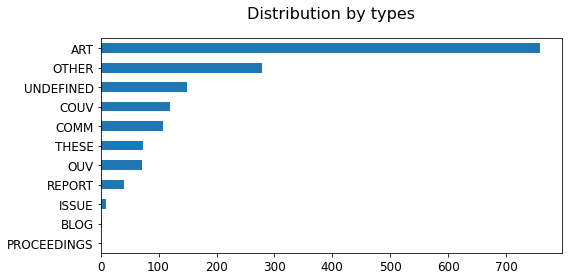

[2023-04-02 17:17:41][INFO ][<module>#5] Number of document without docType_s: 0
[2023-04-02 17:17:41][INFO ][<module>#6] Number of document types: 11


,docType_s,count
10,PROCEEDINGS,1
9,BLOG,2
8,ISSUE,9
7,REPORT,40
6,OUV,71
5,THESE,73
4,COMM,107
3,COUV,119
2,UNDEFINED,149
1,OTHER,278


In [21]:
doc_types = DfOps(df) \
    .count(subset=['docType_s'], column='count') \
    .csv('document_types.csv', index=False) \
    .barh(title='Distribution by types', x='docType_s', y='count')
LOGGER.info('Number of document without docType_s: %d', doc_types[doc_types.docType_s.isnull()]["count"].sum())
LOGGER.info('Number of document types: %d', doc_types["docType_s"].dropna().size)
doc_types

In [22]:
doc_types_others = DfOps(doc_types).group_min_values(
    label_column = 'docType_s',
    value_column = 'count',
    min_value = 40,
    min_label = lambda l: f'{" + ".join(l)}'
)
doc_types_others

[2023-04-02 17:17:41][INFO ][group_min_values#154] Create a new dataframe for other values (others=(col['count'] < 40]) => 4 rows aggreated
[2023-04-02 17:17:41][INFO ][group_min_values#169] New dataframe size: 8 (Original dataframe size: 11)


,docType_s,count
6,ART,758
5,OTHER,278
4,UNDEFINED,149
3,COUV,119
2,COMM,107
1,THESE,73
0,OUV,71
7,PROCEEDINGS + BLOG + ISSUE + REPORT,52


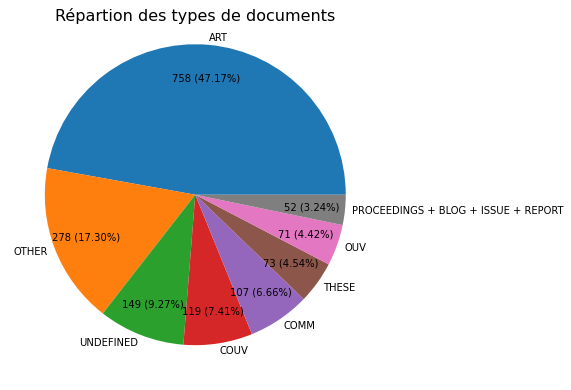

In [23]:
axs = doc_types_others['count'].plot(
    kind='pie',
    subplots=True,
    sharex=False,
    sharey=False,
    #title='Occurence',
    labels=doc_types_others['docType_s'],
    figsize=(8, 8),
    #autopct='%1.1f%%',
    autopct=lambda p: '{total} ({p:.2f}%)'.format(p=p, total=round(p * doc_types_others['count'].sum() / 100)),
    pctdistance=0.78,
    #rotatelabels=False,
    labeldistance=1.05
)
plt.tight_layout()
#plt.figure(1).savefig(occurence_png_target_file)
axs[0].set_ylabel('')
axs[0].set_title('Répartion des types de documents', y=1.0, pad=-14, fontdict={'fontsize': 16})
plt.figure(1).savefig(f'./exports/repartion_des_types_de_documents.png', bbox_inches='tight')
plt.show()

## Audiences

In [24]:
audience_values = {
    '1': 'NOT_SPECIFIED',
    '2': 'INTERNATIONAL',
    '3': 'NATIONAL',
}

audiences = df['audience_s'].apply(lambda x: audience_values.get(str(x or '1'), 'NOT_SPECIFIED')).to_frame()
audiences = audiences[['audience_s']].value_counts(dropna=False).to_frame(name='count').reset_index()
audiences

,audience_s,count
0,INTERNATIONAL,1029
1,NOT_SPECIFIED,545
2,NATIONAL,33


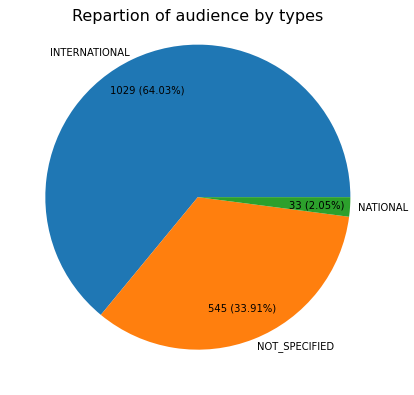

In [25]:
axs = audiences['count'].plot(
    kind='pie',
    subplots=True,
    sharex=False,
    sharey=False,
    #title='Occurence',
    labels=audiences['audience_s'],
    figsize=(6, 6),
    #autopct='%1.1f%%',
    autopct=lambda p: '{total} ({p:.2f}%)'.format(p=p, total=round(p * audiences['count'].sum() / 100)),
    pctdistance=0.78,
    #rotatelabels=False,
    labeldistance=1.05
)
plt.tight_layout()
#plt.figure(1).savefig(occurence_png_target_file)
axs[0].set_ylabel('')
axs[0].set_title('Repartion of audience by types', y=1.0, pad=-14, fontdict={'fontsize': 16})
plt.figure(1).savefig(f'./exports/audience_distribution_pie.png', bbox_inches='tight')
plt.show()

# Articles : Data Processing

In [26]:
df_art = df[df['docType_s'] == 'ART'].drop(columns=['docType_s']).reset_index(drop=True)
df_art

,label_s,openAccess_bool,peerReviewing_s,audience_s,jel_s,keyword_s,journalTitle_s,journalIssn_s,anrProjectTitle_s,anrProjectAcronym_s,...,instStructName_s,instStructCountry_s,contributorFullName_s,language_s,uri_s,files_s,authStructId_i,funding_s,europeanProjectAcronym_s,europeanProjectReference_s
0,"Nicolas Jacquemet, Stéphane Luchini, Jason F S...",True,1,2,"[C.C7.C72, D.D8.D83]","[Coordination game, Cheap talk communication, ...",Experimental Economics,1386-4157,"[Opening economics, PROJET AVENIR LYON SAINT-E...","[OSE, Avenir L.S.E., BECOA]",...,"[Université Paris 1 Panthéon-Sorbonne, Univers...","[fr, fr, fr, fr, fr, fr, fr, fr, fr, fr, fr, f...",Nicolas Jacquemet,[en],https://shs.hal.science/halshs-01480525,[https://shs.hal.science/halshs-01480525/file/...,NaN,NaN,NaN,NaN
1,"Lionel Fontagné, Jean Fouré, Alexander Keck. S...",True,1,2,"[E.E2.E27, F.F0.F02, F.F1.F17, F.F4.F47]","[International trade, Macroeconomic projection...",The World Economy,0378-5920,NaN,NaN,...,"[Université Paris 1 Panthéon-Sorbonne, École n...","[fr, fr, fr, fr, fr, fr, fr, fr]",Lionel Fontagné,[en],https://hal.science/hal-01416567,NaN,[15080],NaN,NaN,NaN
2,"Ziaul Haque Munim, Hercules Haralambides. Adva...",True,1,2,NaN,NaN,Maritime Economics and Logistics,1479-2931,NaN,NaN,...,"[University of South-Eastern Norway, Dalian Ma...","[no, cn, fr]",Amélie COLLIN,[en],https://hal.science/hal-04046263,NaN,NaN,NaN,NaN,NaN
3,"Claire Gavard, Djamel Kirat. Flexibility in th...",True,1,2,NaN,[European allowances International credits Emi...,Energy Economics,0140-9883,"[Geofluids and Volatil elements – Earth, Atmos...",[VOLTAIRE],...,"[Universität Mannheim [Mannheim], Université P...","[de, fr, fr, fr]",Nathalie POTHIER,[en],https://hal-insu.archives-ouvertes.fr/insu-019...,[https://hal-insu.archives-ouvertes.fr/insu-01...,NaN,NaN,NaN,NaN
4,"Stefano Bosi, Thai Ha-Huy, Cuong Le Van, Cao-T...",True,1,2,NaN,"[Forward altruism, Overlapping generations, Ca...",Journal of Mathematical Economics,0304-4068,[Modèles Mathématiques et Economiques de la Dy...,"[MME-DII, Entreprendre]",...,"[Université d'Évry-Val-d'Essonne, Université P...","[fr, fr, fr, fr, fr, fr, fr, fr, fr]",Univ Évry HAL,[en],https://hal.science/hal-02878049,NaN,NaN,[The authors are very grateful to anonymous re...,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
753,"Francois-Xavier Devetter, Julie Valentin. Pola...",False,1,2,NaN,"[Job quality, Polarization, Cleaning, Segmenta...",Revue de l'OFCE,1265-9576,NaN,NaN,...,"[Université Paris 1 Panthéon-Sorbonne, Univers...","[fr, fr]",LillOA Université de Lille,[fr],https://hal.univ-lille.fr/hal-03367431,NaN,NaN,NaN,NaN,NaN
754,"Youenn Loheac, Hayyan Alia, Cécile Bazart, Moh...",True,1,2,"[A.A1.A11, C.C9.C93]","[Grand public, Expérience, Vulgarisation, Péda...",Revue Economique,0035-2764,NaN,NaN,...,"[Université de Caen Normandie, Université de R...","[fr, fr, fr, fr, fr, fr, fr, fr, fr, fr, fr, f...",Taï Dao,[fr],https://shs.hal.science/halshs-01321452,[https://shs.hal.science/halshs-01321452/file/...,NaN,NaN,NaN,NaN
755,"Rémi Bazillier, Jérôme Héricourt, Samuel Ligon...",False,1,2,"[D.D3.D31, E.E2.E25, E.E4.E44, G.G0.G01]",NaN,Revue d'économie financière,0987-3368,NaN,NaN,...,"[Université Paris 1 Panthéon-Sorbonne, Univers...","[fr, fr, fr, fr]",marion romo,[en],https://hal.science/hal-01744554,NaN,NaN,NaN,NaN,NaN
756,"Maria Bas, Pamela Bombarda, Sébastien Jean, Gi...",True,1,2,"[F.F1, F.F1.F16, L.L2.L25, L.L6.L60]","[Export intensity, Employment volatility, Skil...",European Economic Review,0014-2921,"[Mondialisation, Qualité des Produits et March...",[MOQAT],...,"[Université Paris 1 Panthéon-Sorbonne, CY Cerg...","[fr, fr, fr, fr, fr, fr, fr, fr, fr, fr]",Regis Grateau,[en],https://hal.inrae.fr/hal-03403887,NaN,NaN,NaN,NaN,NaN


## Keywords

Count the number of keywords for all articles

In [27]:
keywords = df_art.explode('keyword_s')
keywords = keywords[['keyword_s']].value_counts(dropna=False).to_frame(name='count').reset_index()
keywords.to_csv(path_or_buf='./exports/keywords.csv', index=False)
LOGGER.info('Number of articles without keywords: %d', keywords[keywords.keyword_s.isnull()]["count"].sum())
LOGGER.info('Number of keywords: %d', keywords["keyword_s"].dropna().size)
keywords.head(n=5)

[2023-04-02 17:17:41][INFO ][<module>#4] Number of articles without keywords: 269
[2023-04-02 17:17:41][INFO ][<module>#5] Number of keywords: 2085


,keyword_s,count
0,NaN,269
1,France,18
2,Metacognition,10
3,Confidence,10
4,China,9


In [28]:
top_count_keywords = keywords.dropna()
top_count_keywords = top_count_keywords[top_count_keywords['count'] >= 4].sort_values(by=['count']).reset_index().sort_values(by=['count'], ascending=False)
top_count_keywords

,index,keyword_s,count
44,1,France,18
43,2,Metacognition,10
42,3,Confidence,10
41,4,China,9
40,5,Regulation,9
39,6,Governance,9
38,7,Inequality,8
37,8,Institutions,8
35,12,Ambiguity,7
33,9,Malaria,7


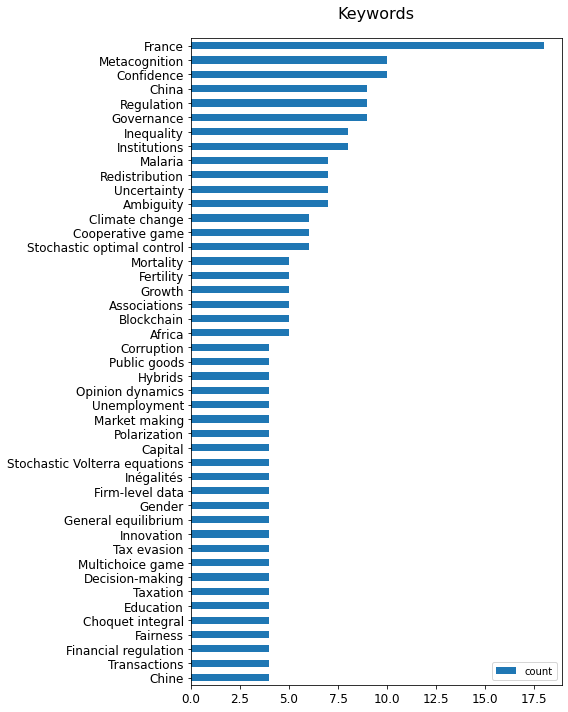

In [29]:
p = top_count_keywords.sort_values(by=['count'], ascending=True).plot(
    kind='barh',
    title='Keywords',
    x='keyword_s',
    y='count',
    xlabel='',
    ylabel='',
    figsize=(8, 10),
    rot=0,
    fontsize=12
)
p.set_title('Keywords', pad=20, fontdict={'fontsize': 16})
plt.tight_layout()
p.get_figure().savefig(f'./exports/keywords_repartition.png', bbox_inches='tight')

## Journals

### Journals occurrences 

In [30]:
journals = df_art[['journalTitle_s']].value_counts(dropna=False).to_frame(name='count').reset_index()
journals.to_csv(path_or_buf='./exports/journals.csv', index=False)
LOGGER.info('Number of journals : %d', journals["journalTitle_s"].size)
journals.head(n=5)

[2023-04-02 17:17:42][INFO ][<module>#3] Number of journals : 397


,journalTitle_s,count
0,Revue Economique,17
1,Journal of Mathematical Economics,17
2,Journal of Economic Behavior and Organization,12
3,Economic Theory,9
4,Revue française des affaires sociales,9


In [31]:
top_count_journals = journals[journals['count'] >= 4].sort_values(by=['count'], ascending=False)
top_count_journals

,journalTitle_s,count
0,Revue Economique,17
1,Journal of Mathematical Economics,17
2,Journal of Economic Behavior and Organization,12
3,Economic Theory,9
4,Revue française des affaires sociales,9
5,Socio-économie du travail,8
6,Scientific Reports,8
7,Theory and Decision,7
8,Revue d'Economie Politique,7
9,Mathematical Social Sciences,7


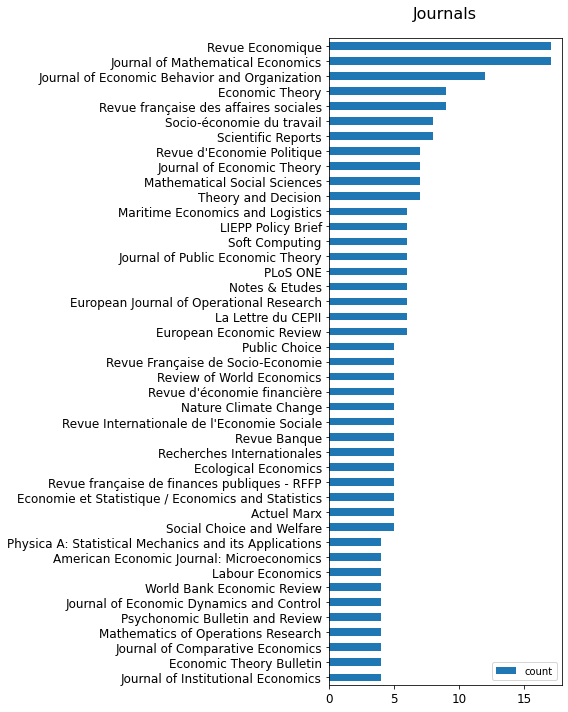

In [32]:
p = top_count_journals.sort_values(by=['count']).plot(
    kind='barh',
    title='Journals',
    x='journalTitle_s',
    y='count',
    xlabel='',
    ylabel='',
    figsize=(8, 10),
    fontsize=12
)
p.set_title('Journals', pad=20, fontdict={'fontsize': 16})
plt.tight_layout()
p.get_figure().savefig(f'./exports/journals_repartition.png', bbox_inches='tight')

### Journal without ISSN

In [33]:
journal_without_issns = df_art[df_art.journalIssn_s.isnull()][['uri_s', 'journalTitle_s']].reset_index(drop=True)
journal_without_issns.to_csv(f'./exports/journals_without_issn.csv', index=False)
journal_without_issns

,uri_s,journalTitle_s
0,https://hal.science/hal-01824123,History of Economic Thought
1,https://hal.science/hal-04002664,Management Science
2,https://shs.hal.science/halshs-03277342,Frontiers in Psychology
3,https://hal.science/hal-03503979,"政治经济学季刊 (zhèngzhì jīngjì xué jìkān, Quarterly ..."
4,https://hal-sciencespo.archives-ouvertes.fr/ha...,LIEPP Policy Brief
5,https://hal.science/hal-03384804,LIEPP Policy Brief
6,https://hal.science/hal-03968639,Notes & Etudes
7,https://hal.science/hal-03973713,Notes & Etudes
8,https://shs.hal.science/halshs-02303437,Global Labour Column
9,https://hal.science/hal-03680071,SIAM Journal on Financial Mathematics


## JEL

In [34]:
# Number of Non NA Values
df_art[['uri_s', 'jel_s']].count()

uri_s    758
jel_s    280
dtype: int64

In [35]:
jels = df_art[['uri_s', 'jel_s']].explode('jel_s')
jels.to_csv(path_or_buf='./exports/jels.csv', index=False)
jels = jels.dropna()
jels

,uri_s,jel_s
0,https://shs.hal.science/halshs-01480525,C.C7.C72
0,https://shs.hal.science/halshs-01480525,D.D8.D83
1,https://hal.science/hal-01416567,E.E2.E27
1,https://hal.science/hal-01416567,F.F0.F02
1,https://hal.science/hal-01416567,F.F1.F17
...,...,...
756,https://hal.inrae.fr/hal-03403887,F.F1
756,https://hal.inrae.fr/hal-03403887,F.F1.F16
756,https://hal.inrae.fr/hal-03403887,L.L2.L25
756,https://hal.inrae.fr/hal-03403887,L.L6.L60


In [36]:
jels['jel_s_code'] = jels['jel_s'].apply(lambda x: x.split('.')[0])
count_jels = jels.value_counts(subset=['jel_s_code']).to_frame(name='count').reset_index()
count_jels

,jel_s_code,count
0,D,195
1,C,153
2,J,87
3,E,67
4,O,67
5,G,65
6,F,55
7,H,45
8,L,38
9,B,34


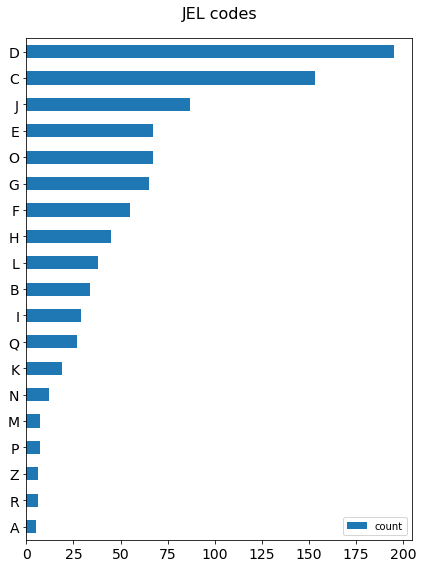

In [37]:
p = count_jels.sort_values(by=['count']).plot(
    kind='barh',
    title='JEL',
    x='jel_s_code',
    y='count',
    xlabel='',
    ylabel='',
    figsize=(6, 8),
    fontsize=14,
    rot=0,
)
p.set_title('JEL codes', pad=20, fontdict={'fontsize': 16})
plt.tight_layout()
p.get_figure().savefig(f'./exports/jel_first_level_repartition.png', bbox_inches='tight')

## Funding

In [38]:
def funding_stats(dataframe: pd.core.frame.DataFrame,
                  filename: str,
                  columns: List[str],
                  occurence_params: Dict[str, Any] = dict(),
                  occurence_title_params: Dict[str, Any] = dict(),
                  repartition_params: Dict[str, Any] = dict(),
                  repartition_title_params: Dict[str, Any] = dict(),
                  repartition_group_min: int = 0):
    LOGGER.info(f'Start processing funding for output filename "%s" based on columns: %s', filename, columns)
    
    # Extract dataframe data
    exploded = dataframe.explode(columns)
    exploded = exploded[['uri_s'] + columns]
    DfOps(exploded.dropna()).csv(filename=f'fundings_{filename}_uri.csv', index=False)
    
    # Occurences stats
    occurence_exploded = exploded[columns].value_counts(dropna=True).to_frame(name='count').reset_index()
    DfOps(occurence_exploded).csv(filename=f'fundings_{filename}_occurence.csv', index=False)
    if not occurence_exploded.empty:
        occurence_default_params = dict(
            kind='pie',
            subplots=True,
            sharex=False,
            sharey=False,
            title='Occurence',
            ylabel='',
            labels=occurence_exploded[columns[0]],
            figsize=(12, 12),
            autopct='%1.1f%%',
            pctdistance=0.85,
            rotatelabels=True,
            labeldistance=1.02,
        )
        occurence_params = { **occurence_default_params, **occurence_params }
        axs = occurence_exploded['count'].plot(**{ **occurence_params, 'title': None })
        plt.tight_layout()
        axs[0].set_ylabel('')
        axs[0].set_title(**{
            **dict(
                label=occurence_params['title'],
                y=1.0,
                pad=-14,
                fontdict={'fontsize': 16}
            ),
            **occurence_title_params
        })
        occurence_png_target_file = f'./exports/fundings_{filename}_occurence.png' 
        plt.figure(1).savefig(occurence_png_target_file, bbox_inches='tight')
        plt.show()
        LOGGER.info('Saving figure to "%s"', occurence_png_target_file)
    else:
        LOGGER.info('Skip figure of occurence for "%s" as the dataframe is empty', filename)
        
    
    # Repartition of having value
    count_exploded = exploded.dropna()[['uri_s']].value_counts().to_frame(name='count').reset_index()
    count_exploded = dataframe.merge(count_exploded, how='left', on='uri_s')
    count_exploded = count_exploded[['uri_s', 'count']].fillna(0).astype({'count': int}).drop_duplicates()
    DfOps(count_exploded).csv(filename=f'fundings_{filename}_count.csv', index=False)
    
    repartition_count_exploded = count_exploded[['count']].value_counts().to_frame(name='number_of_count').reset_index()
    DfOps(repartition_count_exploded).csv(filename=f'fundings_{filename}_repartition.csv', index=False)
    
    if not repartition_count_exploded.empty:
        if repartition_group_min > 0:
            repartition_count_exploded = DfOps(repartition_count_exploded).group_min_values(
                label_column = 'count',
                value_column = 'number_of_count',
                min_value = repartition_group_min,
                min_label = lambda l: str(l)
            )
        repartition_default_params = dict(
            kind='pie',
            subplots=True,
            sharex=False,
            sharey=False,
            title='Repartition',
            ylabel='',
            labels=repartition_count_exploded['count'],
            figsize=(12, 12),
            autopct=lambda p: '{total} ({p:.2f}%)'.format(p=p, total=round(p * repartition_count_exploded['number_of_count'].sum() / 100)),
            pctdistance=0.8,
        )
        repartition_params = {**repartition_default_params, **repartition_params}
        axs = repartition_count_exploded['number_of_count'].plot(**{ **repartition_params, 'title': None })
        repartition_count_exploded_png_target_file = f'./exports/fundings_{filename}_repartition.png'
        plt.tight_layout()
        axs[0].set_ylabel('')
        axs[0].set_title(**{
            **dict(
                label=repartition_params['title'],
                y=1.0,
                pad=-14,
                fontdict={'fontsize': 16}
            ),
            **repartition_title_params
        })
        plt.figure(1).savefig(repartition_count_exploded_png_target_file, bbox_inches='tight')
        plt.show()
        LOGGER.info('Saving figure to "%s"', repartition_count_exploded_png_target_file)
    else:
        LOGGER.info('Skip figure of repartition for "%s" as the dataframe is empty', filename)
    
    LOGGER.info('End processing funding for filemane "%s" outputs', filename)


### ANR

[2023-04-02 17:17:42][INFO ][funding_stats#9] Start processing funding for output filename "anr_global" based on columns: ['anrProjectAcronym_s', 'anrProjectReference_s']
[2023-04-02 17:17:43][INFO ][csv#35] Export to CSV file: ./exports/fundings_anr_global_uri.csv (params: {'index': False, 'sep': ';'}) (number of rows: 187)
[2023-04-02 17:17:43][INFO ][csv#35] Export to CSV file: ./exports/fundings_anr_global_occurence.csv (params: {'index': False, 'sep': ';'}) (number of rows: 50)


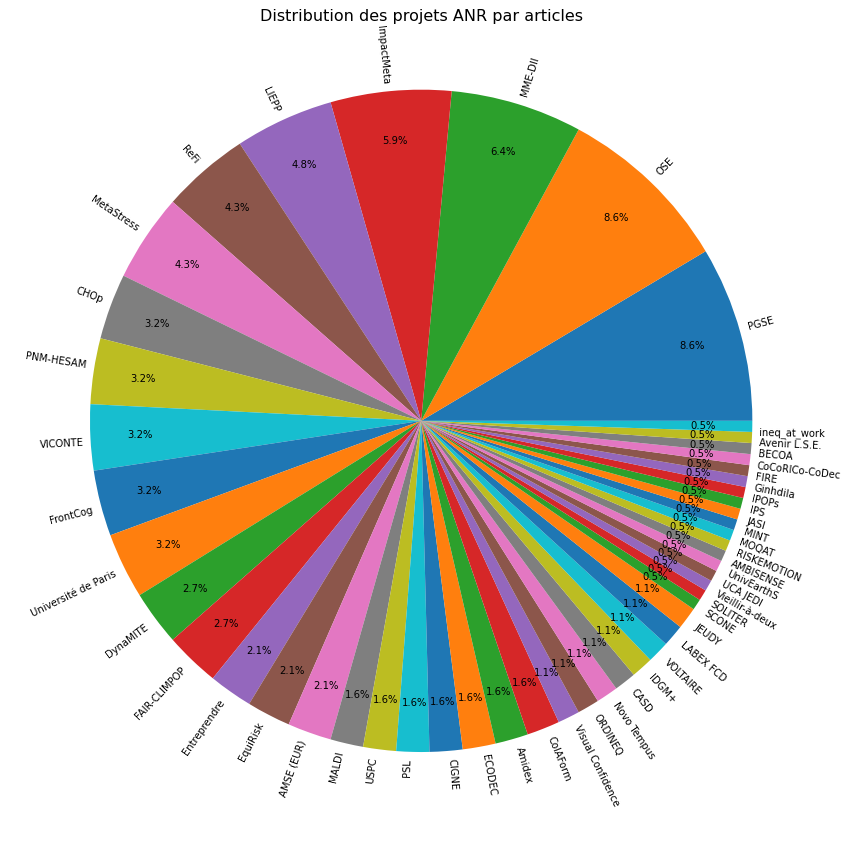

[2023-04-02 17:17:43][INFO ][funding_stats#50] Saving figure to "./exports/fundings_anr_global_occurence.png"
[2023-04-02 17:17:43][INFO ][csv#35] Export to CSV file: ./exports/fundings_anr_global_count.csv (params: {'index': False, 'sep': ';'}) (number of rows: 758)
[2023-04-02 17:17:43][INFO ][csv#35] Export to CSV file: ./exports/fundings_anr_global_repartition.csv (params: {'index': False, 'sep': ';'}) (number of rows: 5)


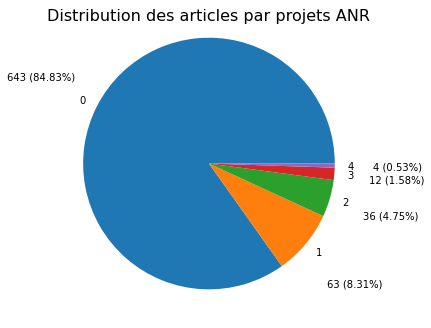

[2023-04-02 17:17:43][INFO ][funding_stats#100] Saving figure to "./exports/fundings_anr_global_repartition.png"
[2023-04-02 17:17:43][INFO ][funding_stats#104] End processing funding for filemane "anr_global" outputs


In [39]:
funding_stats(
    dataframe=df_art,
    columns=['anrProjectAcronym_s', 'anrProjectReference_s'],
    filename='anr_global',
    occurence_params=dict(title='Distribution des projets ANR par articles'),
    repartition_params=dict(title='Distribution des articles par projets ANR', figsize=(6,6), pctdistance=1.5),
)

### European

[2023-04-02 17:17:43][INFO ][funding_stats#9] Start processing funding for output filename "european_global" based on columns: ['europeanProjectAcronym_s', 'europeanProjectReference_s']
[2023-04-02 17:17:43][INFO ][csv#35] Export to CSV file: ./exports/fundings_european_global_uri.csv (params: {'index': False, 'sep': ';'}) (number of rows: 45)
[2023-04-02 17:17:43][INFO ][csv#35] Export to CSV file: ./exports/fundings_european_global_occurence.csv (params: {'index': False, 'sep': ';'}) (number of rows: 28)


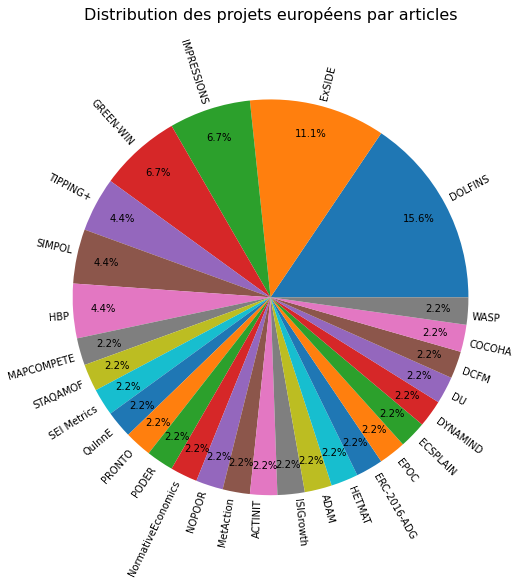

[2023-04-02 17:17:44][INFO ][funding_stats#50] Saving figure to "./exports/fundings_european_global_occurence.png"
[2023-04-02 17:17:44][INFO ][csv#35] Export to CSV file: ./exports/fundings_european_global_count.csv (params: {'index': False, 'sep': ';'}) (number of rows: 758)
[2023-04-02 17:17:44][INFO ][csv#35] Export to CSV file: ./exports/fundings_european_global_repartition.csv (params: {'index': False, 'sep': ';'}) (number of rows: 5)


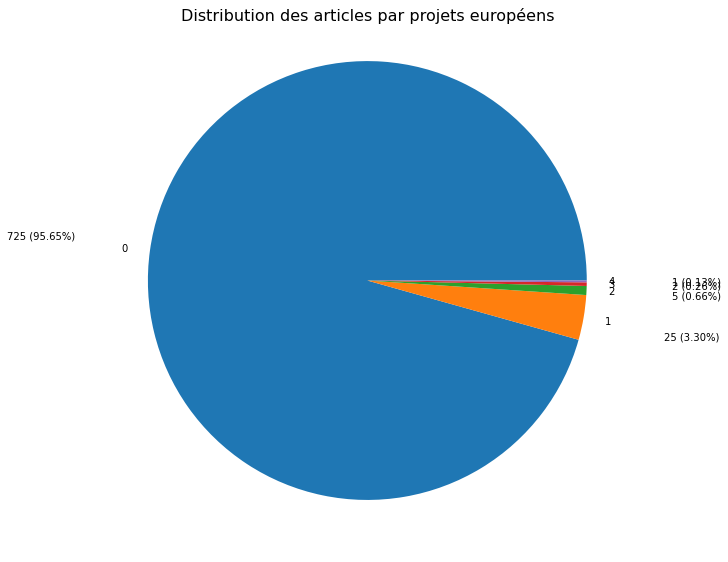

[2023-04-02 17:17:44][INFO ][funding_stats#100] Saving figure to "./exports/fundings_european_global_repartition.png"
[2023-04-02 17:17:44][INFO ][funding_stats#104] End processing funding for filemane "european_global" outputs


In [40]:
funding_stats(
    dataframe = df_art,
    columns = ['europeanProjectAcronym_s', 'europeanProjectReference_s'],
    filename = 'european_global',
    occurence_params = dict(
        title = 'Distribution des projets européens par articles',
        figsize=(8, 8)
    ),
    occurence_title_params = dict(
        pad = 30
    ),
    repartition_params = dict(
        title = 'Distribution des articles par projets européens',
        figsize = (10, 10),
        pctdistance = 1.5
    ),
)

[2023-04-02 17:17:44][INFO ][funding_stats#9] Start processing funding for output filename "european_global_top" based on columns: ['europeanProjectAcronym_s', 'europeanProjectReference_s']
[2023-04-02 17:17:44][INFO ][csv#35] Export to CSV file: ./exports/fundings_european_global_top_uri.csv (params: {'index': False, 'sep': ';'}) (number of rows: 45)
[2023-04-02 17:17:44][INFO ][csv#35] Export to CSV file: ./exports/fundings_european_global_top_occurence.csv (params: {'index': False, 'sep': ';'}) (number of rows: 28)


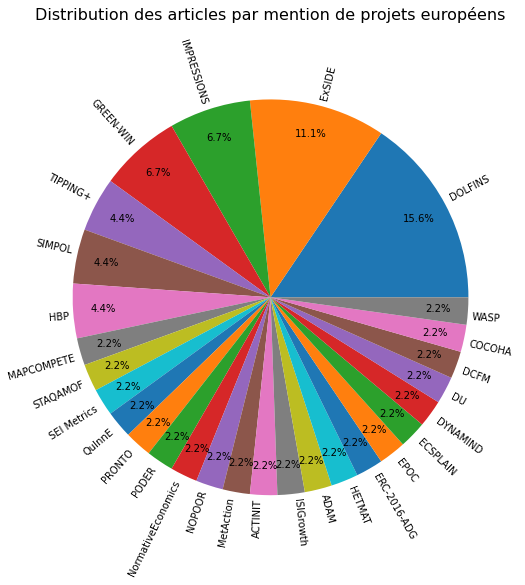

[2023-04-02 17:17:45][INFO ][funding_stats#50] Saving figure to "./exports/fundings_european_global_top_occurence.png"
[2023-04-02 17:17:45][INFO ][csv#35] Export to CSV file: ./exports/fundings_european_global_top_count.csv (params: {'index': False, 'sep': ';'}) (number of rows: 758)
[2023-04-02 17:17:45][INFO ][csv#35] Export to CSV file: ./exports/fundings_european_global_top_repartition.csv (params: {'index': False, 'sep': ';'}) (number of rows: 5)
[2023-04-02 17:17:45][INFO ][group_min_values#154] Create a new dataframe for other values (others=(col['number_of_count'] < 6]) => 3 rows aggreated
[2023-04-02 17:17:45][INFO ][group_min_values#169] New dataframe size: 3 (Original dataframe size: 5)


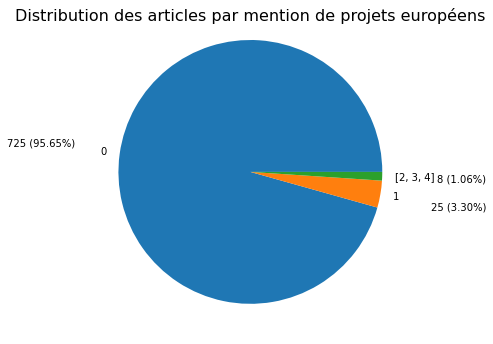

[2023-04-02 17:17:45][INFO ][funding_stats#100] Saving figure to "./exports/fundings_european_global_top_repartition.png"
[2023-04-02 17:17:45][INFO ][funding_stats#104] End processing funding for filemane "european_global_top" outputs


In [41]:
funding_stats(
    dataframe = df_art,
    columns = ['europeanProjectAcronym_s', 'europeanProjectReference_s'],
    filename = 'european_global_top',
    occurence_params = dict(
        title = 'Distribution des articles par mention de projets européens',
        figsize = (8, 8)
    ),
    occurence_title_params = dict(
        pad = 30
    ),
    repartition_params = dict(
        title = 'Distribution des articles par mention de projets européens',
        figsize = (7, 7),
        pctdistance = 1.6
    ),
    repartition_group_min = 6,
)

### Others

In [42]:
other_fundings = df_art.explode(['funding_s'])
other_fundings = other_fundings[['uri_s', 'funding_s']]
other_fundings.dropna().to_csv(path_or_buf='./exports/fundings_other_uri.csv', index=False)
other_fundings = other_fundings[['funding_s']].value_counts(dropna=False).to_frame(name='count').reset_index()
other_fundings.to_csv(path_or_buf='./exports/fundings_other_stats.csv', index=False)
other_fundings.head(n=5)

,funding_s,count
0,NaN,623
1,This work was achieved through the Laboratory ...,2
2,This research was supported by the Agence Nati...,1
3,This research has received funding from the Eu...,1
4,This research was partially funded by ANR prog...,1


## Collaborations

### Structure/institution: Country (instStructCountry_s)

An article, may have several `instStructCountry_s`.

We explode the dataset based on the field `instStructCountry_s` to have only one country by row.

,uri_s,instStructCountry_s
0,https://shs.hal.science/halshs-01480525,fr
0,https://shs.hal.science/halshs-01480525,fr
0,https://shs.hal.science/halshs-01480525,fr
0,https://shs.hal.science/halshs-01480525,fr
0,https://shs.hal.science/halshs-01480525,fr
...,...,...
756,https://hal.inrae.fr/hal-03403887,fr
757,https://hal.science/hal-01726581,fr
757,https://hal.science/hal-01726581,fr
757,https://hal.science/hal-01726581,fr


,instStructCountry_s,count
0,fr,3233
1,us,87
2,gb,60
3,it,48
4,de,44


[2023-04-02 17:17:45][INFO ][csv#35] Export to CSV file: ./exports/colloborations_inst_struct_country.csv (params: {'index': False, 'sep': ';'}) (number of rows: 52)
[2023-04-02 17:17:45][INFO ][barh#77] Export barh graph to PNG file: ./exports/affiliations_des_co-auteurs_par_pays.png


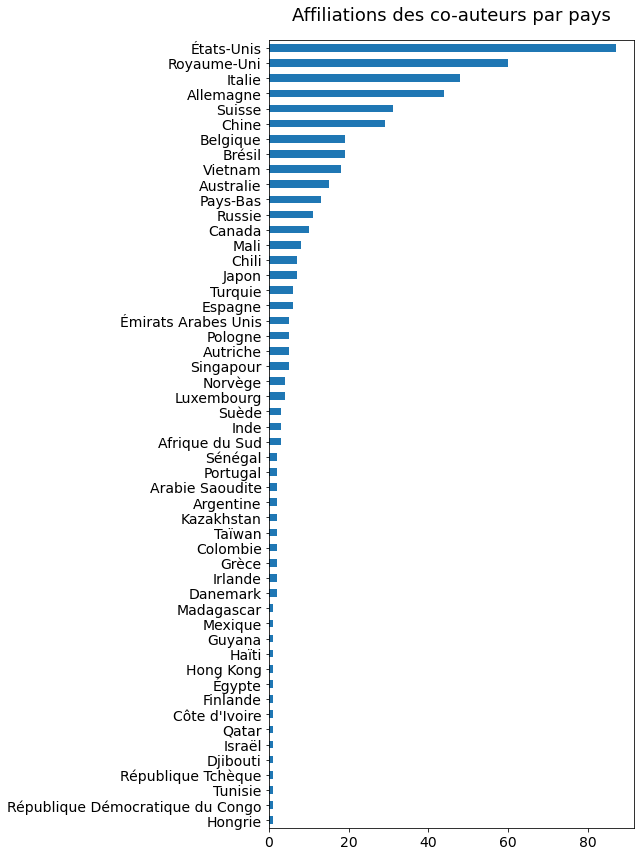

,instStructCountry_s,count,iso,name
0,us,87,us,États-Unis
1,gb,60,gb,Royaume-Uni
2,it,48,it,Italie
3,de,44,de,Allemagne
4,ch,31,ch,Suisse


In [43]:
collaboration_struct_countries = df_art[['uri_s', 'instStructCountry_s']]
collaboration_struct_countries = collaboration_struct_countries.explode(['instStructCountry_s'])
DfOps(collaboration_struct_countries).display()

# Count collaborations by country
collaboration_struct_country_values = DfOps(collaboration_struct_countries) \
    .count(subset=['instStructCountry_s'], column='count') \
    .display_head(n=5)

# Filter for not 'fr' and merge with country dataset
collaboration_struct_country_values = collaboration_struct_country_values[(collaboration_struct_country_values.instStructCountry_s != 'fr')]
collaboration_struct_country_values = collaboration_struct_country_values.merge(
    country_df,
    how='left',
    left_on='instStructCountry_s',
    right_on='iso',
    validate='many_to_one'
)

DfOps(collaboration_struct_country_values) \
    .csv(filename='colloborations_inst_struct_country.csv', index=False) \
    .barh(
        title='Affiliations des co-auteurs par pays',
        x='name',
        y='count',
        plot_params=dict(xlabel='', ylabel='', figsize=(9, 12), fontsize=14, rot=0),
        title_params = dict(pad=20, fontdict={'fontsize':18}),
    )
collaboration_struct_country_values.head(n=5)

### Structure/institution: Name (instStructName_s)

An article, may have several `instStructName_s`.

We explode the dataset based on the field `instStructName_s` to have only one structure by row.

In [44]:
collaboration_struct_names = df_art[['uri_s', 'instStructName_s']]
collaboration_struct_names = collaboration_struct_names.explode(['instStructName_s'])
collaboration_struct_names

,uri_s,instStructName_s
0,https://shs.hal.science/halshs-01480525,Université Paris 1 Panthéon-Sorbonne
0,https://shs.hal.science/halshs-01480525,Université Paris 1 Panthéon-Sorbonne
0,https://shs.hal.science/halshs-01480525,École normale supérieure - Paris
0,https://shs.hal.science/halshs-01480525,École des hautes études en sciences sociales
0,https://shs.hal.science/halshs-01480525,École des Ponts ParisTech
...,...,...
756,https://hal.inrae.fr/hal-03403887,Université Paris Dauphine-PSL
757,https://hal.science/hal-01726581,Université Paris 1 Panthéon-Sorbonne
757,https://hal.science/hal-01726581,Institut national d'études démographiques
757,https://hal.science/hal-01726581,Université Paris 8 Vincennes-Saint-Denis


In [45]:
collaboration_struct_hidden = [
    'Centre National de la Recherche Scientifique',
    'Université Paris 1 Panthéon-Sorbonne',
    'École des hautes études en sciences sociales',
    'École normale supérieure - Paris',
    'École des Ponts ParisTech',
    'Institut National de Recherche pour l’Agriculture, l’Alimentation et l’Environnement',
]
collaboration_struct_name_aggregation_min = 6

collaboration_struct_name_values = collaboration_struct_names[['instStructName_s']].value_counts().to_frame(name='count').reset_index()
collaboration_struct_name_values.to_csv(f'./exports/colloborations_inst_struct_name.csv', index=False)

# TODO : Dirty ....
for csh in collaboration_struct_hidden:
    collaboration_struct_name_values = collaboration_struct_name_values[(collaboration_struct_name_values.instStructName_s != csh)]

# Retrieve small collaboration to create a new row 'others'
collaboration_struct_name_others = collaboration_struct_name_values[(collaboration_struct_name_values['count'] <= collaboration_struct_name_aggregation_min)]
collaboration_struct_name_others_size = collaboration_struct_name_others['instStructName_s'].size
collaboration_struct_name_others = pd.DataFrame(
    dict(
        instStructName_s=f'Others ({collaboration_struct_name_others_size})',
        count=collaboration_struct_name_others['count'].sum()
    ),
    index=[0]
)
# Cleanup base df for collaboration
collaboration_struct_name_top = collaboration_struct_name_values[(collaboration_struct_name_values['count'] > collaboration_struct_name_aggregation_min)]
collaboration_struct_name_values = pd.concat([collaboration_struct_name_top, collaboration_struct_name_others], ignore_index=True)
collaboration_struct_name_values = collaboration_struct_name_values.sort_values(by=['count'], ascending=False)
collaboration_struct_name_values.to_csv(f'./exports/colloborations_inst_struct_name_filtered_{collaboration_struct_name_aggregation_min}.csv', index=False)
collaboration_struct_name_values.head(n=5)

,instStructName_s,count
50,Others (472),763
0,Université Tsinghua de Beijing,35
1,Sciences Po,34
2,IPAG Business School,33
3,Aix Marseille Université,24


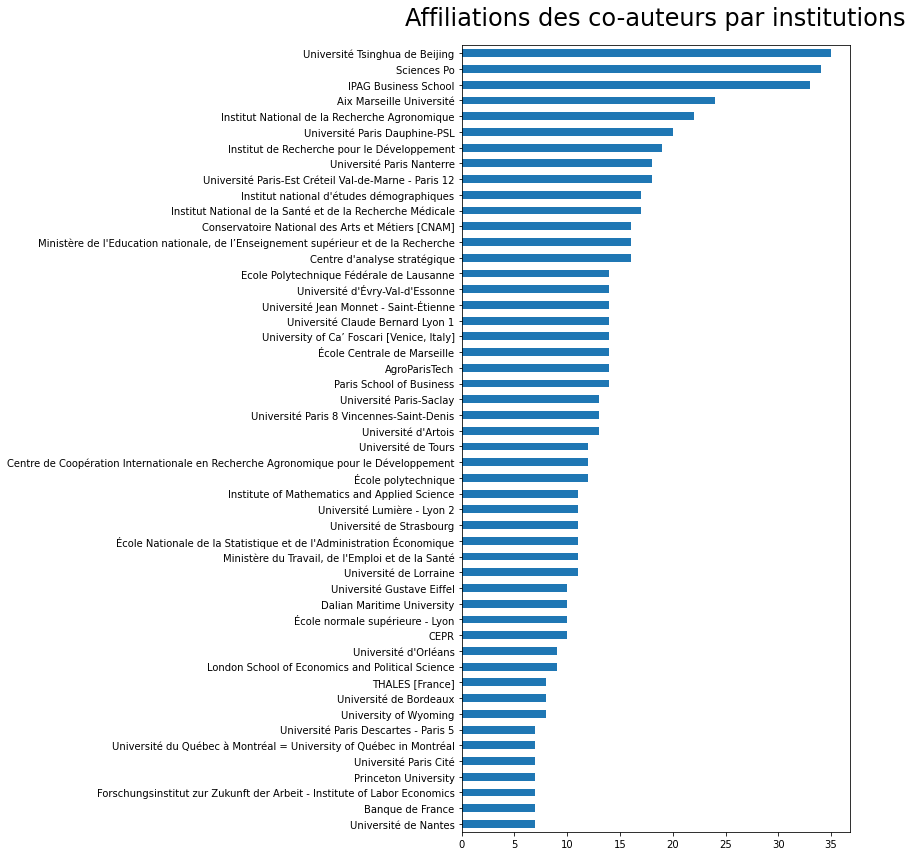

In [46]:
p = collaboration_struct_name_top.sort_values(by=['count']).plot(
    kind='barh',
    title='Collaboration by Institutions',
    x='instStructName_s',
    y='count',
    xlabel='',
    ylabel='',
    figsize=(12, 12),
    legend=False,
)
p.set_title('Affiliations des co-auteurs par institutions', pad=20, fontdict={'fontsize':24})
plt.tight_layout()
p.get_figure().savefig(f'./exports/collaboration_struct_name_count_without_others.png', bbox_inches='tight')

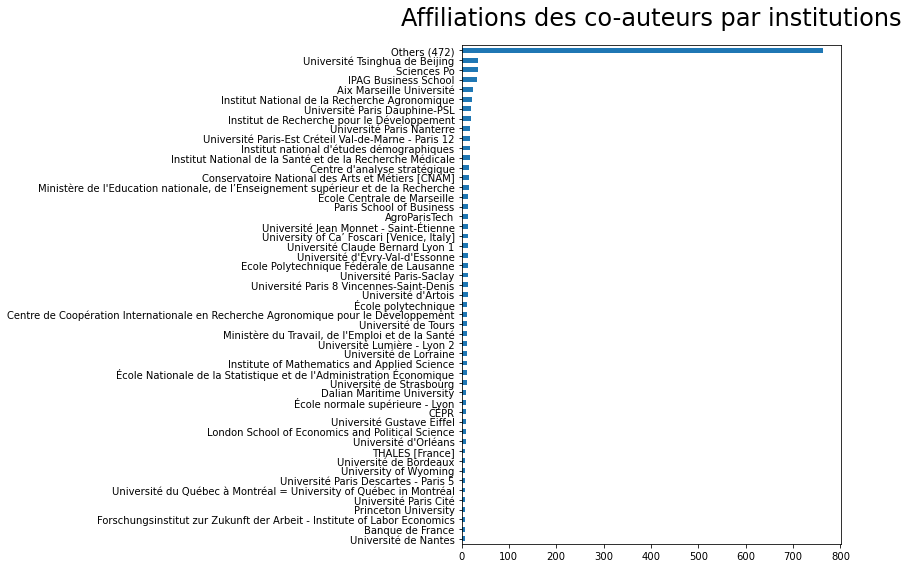

In [47]:
p = collaboration_struct_name_values.sort_values(by=['count']).plot(
    kind='barh',
    title='Collaboration by Institutions',
    x='instStructName_s',
    y='count',
    xlabel='',
    ylabel='',
    figsize=(12, 8),
    legend=False,
)
p.set_title('Affiliations des co-auteurs par institutions', pad=20, fontdict={'fontsize':24})
plt.tight_layout()
p.get_figure().savefig(f'./exports/collaboration_struct_name_count.png', bbox_inches='tight')

## Full text

Also named attached files ...

An article may have multiple attached files. We will count the number of attached files here by document.

In [48]:
def full_text(dataframe,
              title: str,
              filename: Optional[str] = None,
              params: Dict[str, Any] = dict()):
    
    filename = (filename or '').strip()
    prefix_filename = f'full_text_{filename}' if len(filename) > 0 else 'full_text'
    
    attached_files = dataframe[['uri_s', 'files_s']].copy()
    attached_files['attached_files_count'] = attached_files['files_s'].apply(lambda x: len(x) if pd.notnull(x) else 0)
    DfOps(attached_files[['uri_s', 'attached_files_count']]).csv(filename=f'{prefix_filename}.csv', index=False)
     
    attached_files_number = attached_files['attached_files_count'].value_counts().sort_index()
    DfOps(attached_files_number).csv(filename=f'{prefix_filename}_distribution.csv', index=False)
    
    default_params = dict(   
        kind='pie',
        subplots=True,
        sharex=False,
        sharey=False,
        #title=title,
        ylabel='',
        labels=attached_files_number.index.tolist(),
        figsize=(6, 6),
        autopct=lambda p: '{total} ({p:.2f}%)'.format(p=p, total=round(p * attached_files_number.sum() / 100)),
        pctdistance=0.7,
        fontsize=14,
    )
    attached_files_number_png_target_file = f'./exports/{prefix_filename}_distribution.png'
    axs = attached_files_number.plot(**{**default_params, **params})
    plt.tight_layout()
    axs[0].set_ylabel('')
    axs[0].set_title(
        label = title,
        y = 1.0,
        pad = 6,
        fontdict = {'fontsize': 16},
    )
    plt.figure(1).savefig(attached_files_number_png_target_file, bbox_inches='tight')
    plt.show()
    LOGGER.info('Saving figure to : "%s"', attached_files_number_png_target_file)
    return attached_files 

[2023-04-02 17:17:48][INFO ][csv#35] Export to CSV file: ./exports/full_text.csv (params: {'index': False, 'sep': ';'}) (number of rows: 758)
[2023-04-02 17:17:48][INFO ][csv#35] Export to CSV file: ./exports/full_text_distribution.csv (params: {'index': False, 'sep': ';'}) (number of rows: 2)


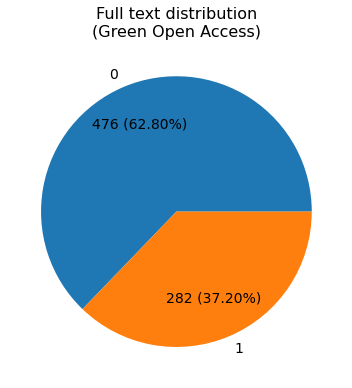

[2023-04-02 17:17:48][INFO ][full_text#41] Saving figure to : "./exports/full_text_distribution.png"


,uri_s,files_s,attached_files_count
0,https://shs.hal.science/halshs-01480525,[https://shs.hal.science/halshs-01480525/file/...,1
1,https://hal.science/hal-01416567,NaN,0
2,https://hal.science/hal-04046263,NaN,0
3,https://hal-insu.archives-ouvertes.fr/insu-019...,[https://hal-insu.archives-ouvertes.fr/insu-01...,1
4,https://hal.science/hal-02878049,NaN,0
...,...,...,...
753,https://hal.univ-lille.fr/hal-03367431,NaN,0
754,https://shs.hal.science/halshs-01321452,[https://shs.hal.science/halshs-01321452/file/...,1
755,https://hal.science/hal-01744554,NaN,0
756,https://hal.inrae.fr/hal-03403887,NaN,0


In [49]:
full_text(
    dataframe=df_art,
    title='Full text distribution\n(Green Open Access)',
    params=dict(
        figsize=(5,5),
        pctdistance=0.70,
        labeldistance=1.1
    )
)

## Open Access

In [50]:
def open_access(dataframe,
                title: str,
                filename: str = None,
                params: Dict[str, Any] = dict()):
    
    filename = (filename or '').strip()
    prefix_filename = f'open_access_{filename}' if len(filename) > 0 else 'open_access'
    
    open_access_number_series = dataframe['openAccess_bool'].value_counts().reindex([True, False])
    open_access_number = open_access_number_series.to_frame(name='count').reset_index()
    DfOps(open_access_number).csv(filename=f'{prefix_filename}_distribution.csv', index=False)
    
    default_params = dict(
        kind='pie',
        subplots=True,
        sharex=False,
        sharey=False,
        #title=title,
        ylabel='',
        labels=open_access_number_series.index.tolist(),
        figsize=(6, 6),
        autopct=lambda p: '{total} ({p:.2f}%)'.format(p=p, total=round(p * open_access_number['count'].sum() / 100)),
        pctdistance=0.7,
        fontsize=14,
    )
    open_access_number_png_target_file = f'./exports/{prefix_filename}_distribution.png'
    axs = open_access_number_series.plot(**{**default_params, **params})
    plt.tight_layout()
    axs[0].set_ylabel('')
    axs[0].set_title(
        label = title,
        y = 1.0,
        pad = 6,
        fontdict = {'fontsize': 16},
    )
    plt.figure(1).savefig(open_access_number_png_target_file, bbox_inches='tight')
    plt.show()
    LOGGER.info('Saving figure to: "%s"', open_access_number_png_target_file)
    
    return open_access_number

[2023-04-02 17:17:48][INFO ][csv#35] Export to CSV file: ./exports/open_access_distribution.csv (params: {'index': False, 'sep': ';'}) (number of rows: 2)


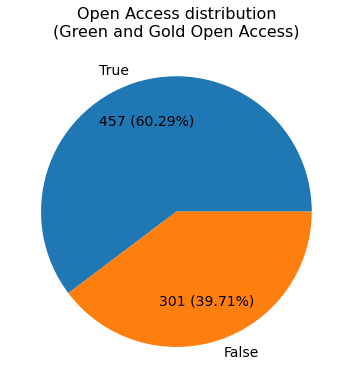

[2023-04-02 17:17:48][INFO ][open_access#38] Saving figure to: "./exports/open_access_distribution.png"


,index,count
0,True,457
1,False,301


In [51]:
open_access(
    dataframe=df_art,
    title='Open Access distribution\n(Green and Gold Open Access)',
    params=dict(
        figsize=(5,5),
        pctdistance=0.70,
        labeldistance=1.1
    )
)

## Ranking



In [52]:
def create_ranking_journals_df(dataframe: pd.core.frame.DataFrame,
                               filename_prefix: Optional[str] = None,
                               excludes: Optional[List[str]] = None):
    excludes = excludes or []
    includes = [i for i in ['ECONLIT', 'MATHSCINET', 'SCIMAGO', 'HCERES'] if i not in excludes]
    LOGGER.info('Create ranking dataframe including: %s (excludes=%s)', includes, excludes)
    
    
    ranking_journals = dataframe[['uri_s', 'journalTitle_s', 'journalIssn_s']].copy()
    ranking_journals['ISSN'] = ranking_journals['journalIssn_s']
    # Econlit
    if 'ECONLIT' in includes:
        ranking_journals = ranking_journals.merge(econlit_df, how='left', on='ISSN', validate='many_to_one')
        ranking_journals['ECONLIT'] = ranking_journals['Title'].notnull()
        ranking_journals = ranking_journals.drop(columns=['Title'])
    
    # MathSciNet
    if 'MATHSCINET' in includes:
        ranking_journals = ranking_journals.merge(mathscinet_df, how='left', on='ISSN', validate='many_to_one')
        ranking_journals['MATHSCINET'] = ranking_journals['Title'].notnull()
        ranking_journals = ranking_journals.drop(columns=['Title'])
    
    # Scimago
    if 'SCIMAGO' in includes:
        ranking_journals = ranking_journals.merge(scimagojr_df, how='left', on='ISSN', validate='many_to_one')
        ranking_journals['SCIMAGO'] = ranking_journals['Title'].notnull()
        ranking_journals = ranking_journals.drop(columns=['Title']).rename(columns={'CATEGORIES': 'SCIMAGO_CATEGORIES'})
    
    # HCERES
    if 'HCERES' in includes:
        ranking_journals = ranking_journals.merge(hceres_df, how='left', on='ISSN', validate='many_to_one')
        ranking_journals = ranking_journals.drop(columns=['Title'])
        ranking_journals['HCERES'] = ranking_journals['HCERES_2021'].notnull()
        ranking_journals = ranking_journals.rename(columns={'HCERES_2021': 'HCERES_RANK', 'CoNRS_2020': 'HCERES_CONRS_RANK', 'FNEGE_2019': 'HCERES_FNEGE_RANK'})
    
    # HCERES + Scimago + MathSciNet + Econlit (if includes)
    ranking_journals['NUMBER_OF_REFERENTIALS'] = ranking_journals[includes].apply(lambda x: x.sum(), axis=1, raw=True)
    
    # Cleanup data
    ranking_journals = ranking_journals.drop(columns=['ISSN'])
    if filename_prefix:
        DfOps(ranking_journals).csv(filename=f'{filename_prefix}.csv', index=False)
    
    return ranking_journals

In [53]:
def journals_ranking_plot(dataframe: pd.core.frame.DataFrame,
                          titles: Dict[str, str] = dict(),
                          filename_prefix: str = 'rankings'):
    titles = titles or {}
    possible_columns = ['MATHSCINET', 'SCIMAGO', 'ECONLIT', 'HCERES']
    columns = [i for i in possible_columns if i in dataframe]
    
    if not columns:
        LOGGER.warn('Cannot plot journals ranking as there is no columns in: %s', possible_columns)
        return
    
    target_file_filtered = f'./exports/{filename_prefix}_filtered.csv'
    DfOps(dataframe[['uri_s'] + columns]).csv(filename=f'{filename_prefix}_filtered.csv', index=False)
    
    ranking_aggregation_transposed = dataframe[columns].apply(pd.Series.value_counts).transpose().fillna(0)
    DfOps(ranking_aggregation_transposed).csv(filename=f'{filename_prefix}_count.csv', index=False)

    true_values = ranking_aggregation_transposed[True].tolist()
    true_labels = round(100 * ranking_aggregation_transposed[True] / ranking_aggregation_transposed.sum(axis='columns'), 1)
    true_labels = ranking_aggregation_transposed[True].combine(true_labels, func=lambda v, p: f'{v} ({p}%)').tolist()

    false_values = ranking_aggregation_transposed[False].tolist()
    false_labels = round(100 * ranking_aggregation_transposed[False] / ranking_aggregation_transposed.sum(axis='columns'), 1)
    false_labels = ranking_aggregation_transposed[False].combine(false_labels, func=lambda v, p: f'{v} ({p}%)').tolist()

    ind = np.arange(len(true_values)) 
    width = 0.60

    fig, ax = plt.subplots(figsize=(12,6))

    true_plot = ax.barh(columns, true_values, width, label='True', linewidth=0 )
    false_plot = ax.barh(columns, false_values, width, left=true_values, label='False', linewidth=0)

    title = 'Articles ranking'
    LOGGER.debug('Retrieve title using key: %s (default: %s)', title, title)
    title = titles.get('Articles ranking', 'Articles ranking')
    ax.set_title(title, pad=10, fontsize=18)
    ax.set_xlabel('Articles', fontsize=13)
    ax.bar_label(true_plot, label_type='center', fontsize=13, labels=true_labels)
    ax.bar_label(false_plot, label_type='center', fontsize=13, labels=false_labels)
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=13)
    fig.tight_layout()
    target_file_general = f'./exports/{filename_prefix}_general.png'
    fig.savefig(target_file_general, bbox_inches='tight')
    LOGGER.info('Saved figure at "%s"', target_file_general)
    plt.show()

In [54]:
def hceres_ranking_plot(dataframe: pd.core.frame.DataFrame,
                        titles: Dict[str, str] = dict(),
                        filename_prefix: str = 'rankings',
                        params:Dict[str, Any] = dict()):
    if 'HCERES_RANK' not in dataframe:
        LOGGER.warn('Skip plotting HCERES as "HCERES_RANK" is not a column of the DataFrame')
        return
    
    titles = titles or {}
    title = 'HCERES articles ranking'
    LOGGER.debug('Retrieve title using key: %s (default=%s)', title, title) 
    title = titles.get(title, title)
    
    LOGGER.info('Create ranking plot "%s" for HCERES (params=%s)', title, params)
    hceres_rankings = dataframe['HCERES_RANK'].dropna().value_counts().sort_index()
    DfOps(hceres_rankings.to_frame(name='count_hceres_ranks')).csv(filename=f'{filename_prefix}_hceres.csv', index=False)
    default_params = dict(
        kind='pie',
        subplots=True,
        sharex=False,
        sharey=False,
        ylabel='',
        labels=hceres_rankings.index.tolist(),
        figsize=(6, 6),
        autopct=lambda p: '{total} ({p:.2f}%)'.format(p=p, total=round(p * hceres_rankings.sum() / 100)),
        pctdistance=0.6,
        fontsize=14,
    )
    hceres_rankings.plot(**{**default_params, **params})
   
    plt.figure(1).axes[0].set_title(title, pad=0, fontdict={'fontsize':15})
    plt.tight_layout()
    target_file_png = f'./exports/{filename_prefix}_hceres.png'
    plt.figure(1).savefig(target_file_png, bbox_inches='tight')
    LOGGER.info('Saved figure at "%s"', target_file_png)
    plt.show()

In [55]:
def create_scimajo_df(dataframe: pd.core.frame.DataFrame,
                      filename_prefix: str = 'rankings',
                      suffix: int = 0,
                      quantile: float = 0.0) -> pd.core.frame.DataFrame:
    
    if 'SCIMAGO_CATEGORIES' not in dataframe:
        LOGGER.warn('Cannot create scimajo dataframe as "SCIMAGO_CATEGORIES" column doesn\'t exist')
        return pd.DataFrame()
    
    scimagojr_categories = dataframe[['uri_s', 'journalTitle_s', 'SCIMAGO_CATEGORIES']].copy().dropna()
    scimagojr_categories['CATEGORY'] = scimagojr_categories['SCIMAGO_CATEGORIES'].str.split(';')
    scimagojr_categories = scimagojr_categories.explode('CATEGORY')
    scimagojr_categories['CATEGORY'] = scimagojr_categories['CATEGORY'].str.strip()
    scimagojr_categories['SCIMAGO_JOURNAL_RANKING'] = scimagojr_categories['CATEGORY'].str.extract('^.*\((?P<sjr>Q[1-4])\)\s*$')
    scimagojr_categories['CATEGORY_WITHOUT_SJR'] = scimagojr_categories['CATEGORY'].str.extract('^(?P<cat>.*)\s+\(Q[1-4]\)\s*$')
    scimagojr_categories = scimagojr_categories.reset_index(drop=True)
    target_file = f'./exports/{filename_prefix}_scimago.csv'
    scimagojr_categories.to_csv(target_file, index=False)
    LOGGER.info('Saved CSV at "%s"', target_file)
    
    # Add a category others when we have to small values
    if quantile > 0:
        LOGGER.info('Rework dataframe to group the less used categories (quantile=%f)', quantile)
        scimagojr_category_names = scimagojr_categories['CATEGORY_WITHOUT_SJR'].value_counts()
        bottom_value = scimagojr_category_names.quantile(q=quantile)
        less_freq_scimagojr_category_names = scimagojr_category_names[scimagojr_category_names <= bottom_value]
        scimagojr_categories.loc[scimagojr_categories['CATEGORY_WITHOUT_SJR'].isin(less_freq_scimagojr_category_names.index.tolist())] = "Others"
    
    target_file_filtered = f'./exports/{filename_prefix}_scimago_filtered_{suffix}.csv'
    scimagojr_categories.to_csv(target_file_filtered, index=False)
    LOGGER.info('Saved CSV at "%s', target_file_filtered)
    
    # Create a new column with category with percent (for the occurence of this category)
    scimagojr_category_names = scimagojr_categories['CATEGORY_WITHOUT_SJR'].value_counts().to_frame().reset_index()
    scimagojr_category_names = scimagojr_category_names.rename(columns={'index': 'CATEGORY_WITHOUT_SJR', 'CATEGORY_WITHOUT_SJR': 'CATEGORY_WITHOUT_SJR_COUNT'})
    scimagojr_category_names['CATEGORY_WITHOUT_JSR_PERCENT'] = scimagojr_category_names.apply(
        lambda row: '{n} - {v} ({p}%)'.format(
            n = row['CATEGORY_WITHOUT_SJR'],
            v = row['CATEGORY_WITHOUT_SJR_COUNT'],
            p = round(100 * row['CATEGORY_WITHOUT_SJR_COUNT'] / scimagojr_category_names['CATEGORY_WITHOUT_SJR_COUNT'].sum(), 1)
        ),
        axis='columns'
    )

    # Merge with initial dataframe
    scimagojr_categories = scimagojr_categories.merge(scimagojr_category_names, how='inner', on=['CATEGORY_WITHOUT_SJR'])
    
    return scimagojr_categories

In [56]:
def scimago_ranking_plot(dataframe: pd.core.frame.DataFrame,
                         titles: Dict[str, str] = dict(),
                         filename_prefix: str = 'rankings',
                         suffix: int = 0,
                         category_params:Dict[str, Any] = dict()):
    if 'CATEGORY_WITHOUT_JSR_PERCENT' not in dataframe:
        LOGGER.warn('Skip plotting Scimago as "CATEGORY_WITHOUT_JSR_PERCENT" is not a column of the DataFrame')
    
    titles = titles or {}
    
    # Fig 1 : Category
    scimago_category_names = dataframe['CATEGORY_WITHOUT_JSR_PERCENT'].value_counts()
    default_category_params = dict(
        kind='pie',
        subplots=True,
        sharex=False,
        sharey=False,
        ylabel='',
        labels=scimago_category_names.index.tolist(),
        figsize=(18, 12),
        autopct=lambda p: '{total} ({p:.2f}%)'.format(p=p, total=round(p * scimago_category_names.sum() / 100)),
        pctdistance=0.9,
        labeldistance=None,
        legend=True
    )
    
    title_categories = 'Scimago JCR: categories'
    LOGGER.debug('Retrieve title using key: %s (default=%s)', title_categories, title_categories)
    title_categories = titles.get(title_categories, title_categories)
    target_file_categories = f'./exports/{filename_prefix}_scimago_categories_{suffix}.png'
    
    scimago_category_names.plot(**{**default_category_params, **category_params})
    plt.legend(loc='best', bbox_to_anchor=(0.1, 0.9))
    plt.figure(1).axes[0].set_title(title_categories, pad=0, fontdict={'fontsize':15})
    plt.tight_layout()
    
    plt.figure(1).savefig(target_file_categories, bbox_inches='tight')
    LOGGER.info('Saved figure at "%s"', target_file_categories)
    plt.show()
    
    # Fig 2 : SJR Repartition
    scimajo_journal_rankings = dataframe['SCIMAGO_JOURNAL_RANKING'].value_counts()
    scimajo_journal_rankings.plot(
        kind='pie',
        subplots=True,
        sharex=False,
        sharey=False,
        ylabel='',
        labels=scimajo_journal_rankings.index.tolist(),
        figsize=(6, 6),
        autopct=lambda p: '{total} ({p:.2f}%)'.format(p=p, total=round(p * scimajo_journal_rankings.sum() / 100)),
        pctdistance=0.7,
        labeldistance=1.1,
    )
    
    title_quartiles = 'Scimago JCR: quartiles'
    LOGGER.debug('Retrieve title using key: %s (default=%s)', title_quartiles, title_quartiles)
    title_quartiles = titles.get(title_quartiles, title_quartiles)
    target_file_quartiles = f'./exports/{filename_prefix}_scimago_sjr_q_score_{suffix}.png'
    
    plt.figure(1).axes[0].set_title(title_quartiles, pad=0, fontdict={'fontsize':15})
    plt.tight_layout()
    plt.figure(1).savefig(target_file_quartiles, bbox_inches='tight')
    LOGGER.info('Saved figure at "%s"', target_file_quartiles)
    plt.show()

In [57]:
def cross_referentials_plot(dataframe: pd.core.frame.DataFrame,
                            titles: Dict[str, str] = dict(),
                            filename_prefix: str = 'rankings'):
    
    titles = titles or {}
    title = 'Distribution of articles'
    LOGGER.debug('Retrieve title using key: %s (default=%s)', title, title)
    title = titles.get(title, title)
    target_file = f'./exports/{filename_prefix}_distribution_of_articles_in_journal_classification_referentials.png'
    
    cross_ref_s = dataframe['NUMBER_OF_REFERENTIALS'].value_counts().sort_index()
    cross_ref_s.plot(
        kind='pie',
        subplots=True,
        sharex=False,
        sharey=False,
        ylabel='',
        labels=cross_ref_s.index.tolist(),
        figsize=(6, 6),
        autopct=lambda p: '{total} ({p:.2f}%)'.format(p=p, total=round(p * cross_ref_s.sum() / 100)),
        pctdistance=0.7,
        labeldistance=1.1,
    )
    plt.figure(1).axes[0].set_title(title, pad=0, fontdict={'fontsize':15})
    plt.tight_layout()
    plt.figure(1).savefig(target_file, bbox_inches='tight')
    LOGGER.info('Saved figure at "%s"', target_file)
    plt.show()

In [58]:
def scimago_hceres_matrix(dataframe: pd.core.frame.DataFrame,
                          filename_prefix: str = 'rankings') -> pd.core.frame.DataFrame:
    if 'HCERES_RANK' not in dataframe or 'SJR_BEST_QUARTILE' not in dataframe:
        LOGGER.warn('Cannot create a matrix for HCERES*Scimago Best Quartile as current dataframe doesn\'t have the columns')
        return pd.DataFrame()

    target_base_file = f'./exports/{filename_prefix}_hceres_scimago_matrix'
    LOGGER.info('Create Scimago / HCERES matrix')
    ranking_scimago_hceres_df = dataframe[['HCERES_RANK', 'SJR_BEST_QUARTILE']].fillna('NON REFERENCE')
    ranking_scimago_hceres_df = ranking_scimago_hceres_df.value_counts(dropna=False)
    
    ranking_scimago_hceres_df.to_excel(f'{target_base_file}.xlsx')
    LOGGER.info('Saved Excel at "%s.xlsx"', target_base_file)
    
    ranking_scimago_hceres_df = ranking_scimago_hceres_df.unstack(fill_value=0)
    ranking_scimago_hceres_df.to_excel(f'{target_base_file}_2.xlsx')
    LOGGER.info('Saved Excel at "%s_2.xlsx"', target_base_file)
    return ranking_scimago_hceres_df

In [59]:
def rankings(dataframe: pd.core.frame.DataFrame,
             titles: Dict[str, str] = dict(),
             excludes: List[str] = [],
             filename_prefix: str = 'rankings',
             hceres_category_params: Dict[str, Any] = dict()):
    LOGGER.info('Process ranking (filename_prefix=%s, titles=%s)', filename_prefix, titles)
    rankings_journals = create_ranking_journals_df(
        dataframe = dataframe,
        excludes = excludes,
        filename_prefix = filename_prefix
    )
    journals_ranking_plot(
        dataframe = rankings_journals,
        titles = titles,
        filename_prefix = filename_prefix
    )
    hceres_ranking_plot(
        dataframe = rankings_journals,
        titles = titles,
        filename_prefix = filename_prefix,
        params = hceres_category_params
    )
    cross_referentials_plot(
        dataframe = rankings_journals,
        titles = titles,
        filename_prefix = filename_prefix
    )
    return rankings_journals

In [60]:
def scimago_rankings(dataframe: pd.core.frame.DataFrame,
                     titles: Dict[str, str] = dict(),
                     filename_prefix: str = 'rankings',
                     suffix: int = 0,
                     quantile: float = 0.0,
                     category_params: Dict[str, Any] = dict()):
    # The input dataframe should be a return of create_ranking_journals_df or rankings
    LOGGER.info('Process scimago rankings (filename_prefix=%s, titles=%s)', filename_prefix, titles) 
    scimajo_df = create_scimajo_df(
        dataframe=dataframe,
        filename_prefix=filename_prefix,
        suffix=suffix,
        quantile=quantile
    )
    scimago_ranking_plot(
        dataframe=scimajo_df,
        titles=titles,
        filename_prefix=filename_prefix,
        suffix=suffix,
        category_params=category_params
    )

### Using all ranking systems

[2023-04-02 17:17:48][INFO ][rankings#6] Process ranking (filename_prefix=rankings, titles={'Articles ranking': 'Distribution of articles\nby journal rating reference system', 'HCERES articles ranking': 'Distribution of articles\nfor the HCERES Vague C 2021 rating reference system', 'Distribution of articles': 'Distribution of articles\nin journal rating reference systems'})
[2023-04-02 17:17:48][INFO ][create_ranking_journals_df#6] Create ranking dataframe including: ['ECONLIT', 'MATHSCINET', 'SCIMAGO', 'HCERES'] (excludes=[])
[2023-04-02 17:17:48][INFO ][csv#35] Export to CSV file: ./exports/rankings.csv (params: {'index': False, 'sep': ';'}) (number of rows: 758)
[2023-04-02 17:17:48][INFO ][csv#35] Export to CSV file: ./exports/rankings_filtered.csv (params: {'index': False, 'sep': ';'}) (number of rows: 758)
[2023-04-02 17:17:48][INFO ][csv#35] Export to CSV file: ./exports/rankings_count.csv (params: {'index': False, 'sep': ';'}) (number of rows: 4)
[2023-04-02 17:17:48][INFO ][j

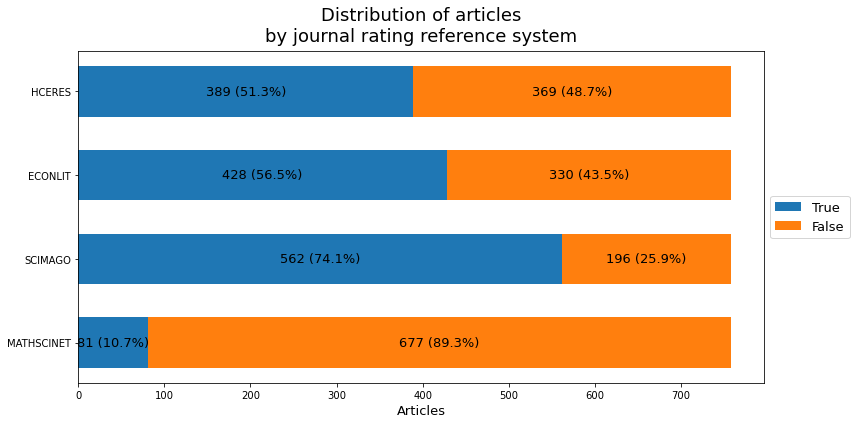

[2023-04-02 17:17:48][INFO ][hceres_ranking_plot#14] Create ranking plot "Distribution of articles
for the HCERES Vague C 2021 rating reference system" for HCERES (params={})
[2023-04-02 17:17:48][INFO ][csv#35] Export to CSV file: ./exports/rankings_hceres.csv (params: {'index': False, 'sep': ';'}) (number of rows: 3)
[2023-04-02 17:17:48][INFO ][hceres_ranking_plot#35] Saved figure at "./exports/rankings_hceres.png"


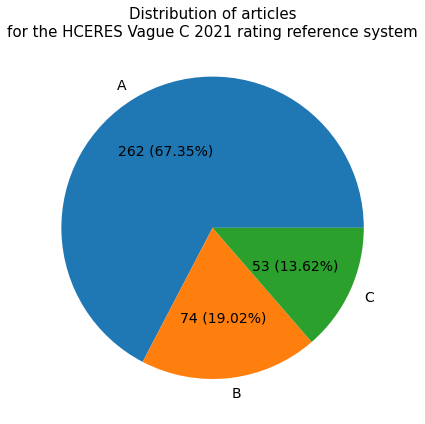

[2023-04-02 17:17:49][INFO ][cross_referentials_plot#27] Saved figure at "./exports/rankings_distribution_of_articles_in_journal_classification_referentials.png"


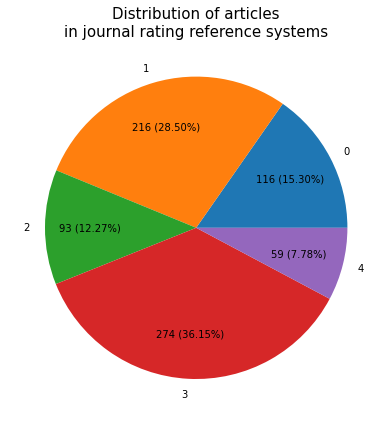

[2023-04-02 17:17:49][INFO ][scimago_hceres_matrix#8] Create Scimago / HCERES matrix
[2023-04-02 17:17:49][INFO ][scimago_hceres_matrix#13] Saved Excel at "./exports/rankings_hceres_scimago_matrix.xlsx"
[2023-04-02 17:17:49][INFO ][scimago_hceres_matrix#17] Saved Excel at "./exports/rankings_hceres_scimago_matrix_2.xlsx"
[2023-04-02 17:17:49][INFO ][scimago_rankings#8] Process scimago rankings (filename_prefix=rankings, titles={'Scimago JCR: categories': 'Distribution of articles by category\nfor the Scimago JCR rating reference system', 'Scimago JCR: quartiles': 'Distribution of articles by quartiles\nfor the Scimago JCR rating reference system'})
[2023-04-02 17:17:49][INFO ][create_scimajo_df#19] Saved CSV at "./exports/rankings_scimago.csv"
[2023-04-02 17:17:49][INFO ][create_scimajo_df#23] Rework dataframe to group the less used categories (quantile=0.600000)
[2023-04-02 17:17:49][INFO ][create_scimajo_df#31] Saved CSV at "./exports/rankings_scimago_filtered_0.csv
[2023-04-02 17:17

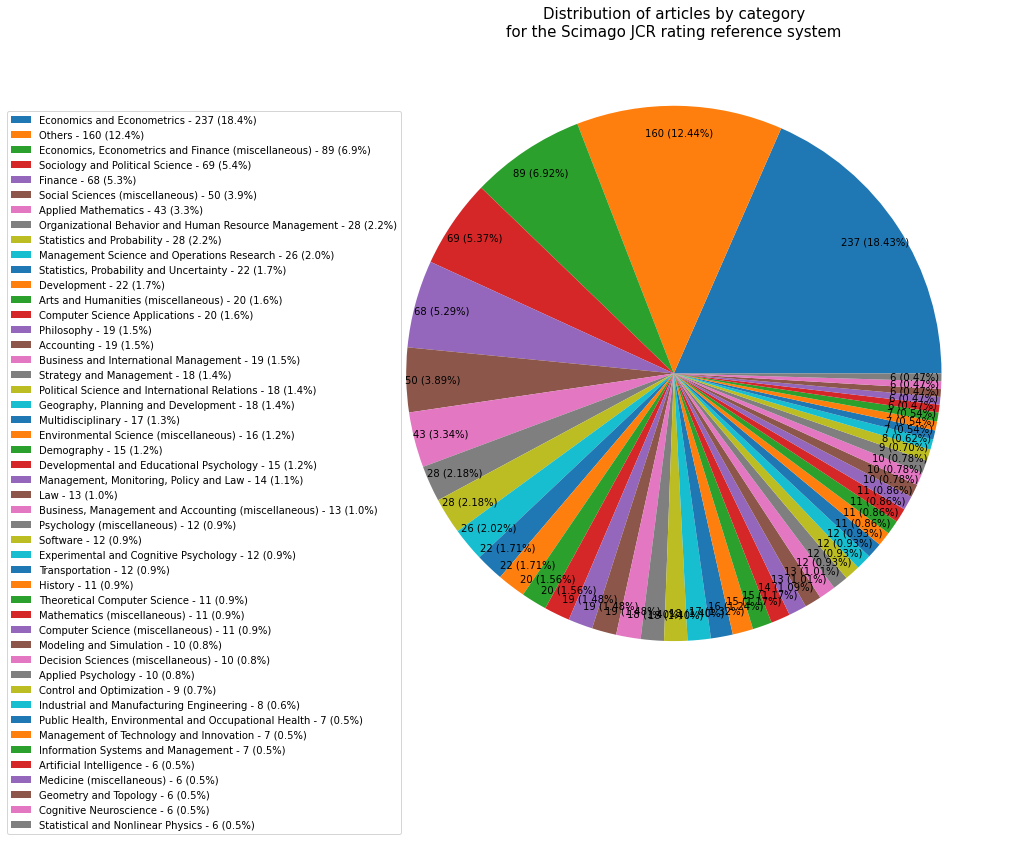

[2023-04-02 17:17:51][INFO ][scimago_ranking_plot#64] Saved figure at "./exports/rankings_scimago_sjr_q_score_0.png"


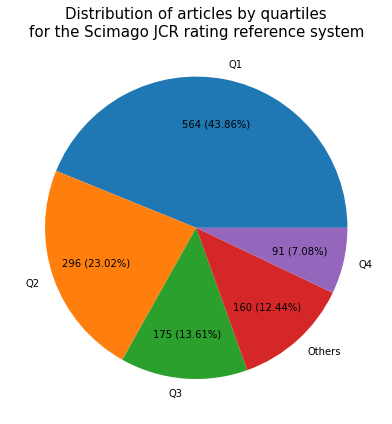

,uri_s,journalTitle_s,journalIssn_s,URL,ECONLIT,MATHSCINET,SCIMAGO_CATEGORIES,SJR_BEST_QUARTILE,SCIMAGO,HCERES_CONRS_RANK,HCERES_FNEGE_RANK,HCERES_RANK,HCERES,NUMBER_OF_REFERENTIALS
0,https://shs.hal.science/halshs-01480525,Experimental Economics,1386-4157,https://link.springer.com/journal/volumesAndIs...,True,False,"Economics, Econometrics and Finance (miscellan...",Q1,True,1,NaN,A,True,3
1,https://hal.science/hal-01416567,The World Economy,0378-5920,https://onlinelibrary.wiley.com/loi/14679701,True,False,Finance (Q1); Political Science and Internatio...,Q1,True,2,NaN,A,True,3
2,https://hal.science/hal-04046263,Maritime Economics and Logistics,1479-2931,https://link.springer.com/journal/volumesAndIs...,True,False,"Economics, Econometrics and Finance (miscellan...",Q1,True,NaN,NaN,NaN,False,2
3,https://hal-insu.archives-ouvertes.fr/insu-019...,Energy Economics,0140-9883,http://www.sciencedirect.com/science/journal/0...,True,False,Economics and Econometrics (Q1); Energy (misce...,Q1,True,2,NaN,A,True,3
4,https://hal.science/hal-02878049,Journal of Mathematical Economics,0304-4068,http://www.sciencedirect.com/science/journal/0...,True,True,Applied Mathematics (Q2); Economics and Econom...,Q2,True,1,NaN,A,True,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
753,https://hal.univ-lille.fr/hal-03367431,Revue de l'OFCE,1265-9576,https://www.cairn.info/revue-de-l-ofce.htm,True,False,"Economics, Econometrics and Finance (miscellan...",Q4,True,4,NaN,C,True,3
754,https://shs.hal.science/halshs-01321452,Revue Economique,0035-2764,https://www.cairn.info/revue-economique.htm,True,False,"Economics, Econometrics and Finance (miscellan...",Q3,True,2,NaN,A,True,3
755,https://hal.science/hal-01744554,Revue d'économie financière,0987-3368,https://www.cairn.info/revue-d-economie-financ...,True,False,NaN,NaN,False,NaN,NaN,NaN,False,1
756,https://hal.inrae.fr/hal-03403887,European Economic Review,0014-2921,http://www.sciencedirect.com/science/journal/0...,True,False,Economics and Econometrics (Q1); Finance (Q1),Q1,True,1,NaN,A,True,3


In [61]:
ranking_df = rankings(
    dataframe=df_art,
    titles={
        'Articles ranking': 'Distribution of articles\nby journal rating reference system',
        'HCERES articles ranking': 'Distribution of articles\nfor the HCERES Vague C 2021 rating reference system',
        'Distribution of articles': 'Distribution of articles\nin journal rating reference systems',
    }
)
scimago_hceres_matrix(dataframe=ranking_df)
scimago_rankings(
    dataframe=ranking_df,
    quantile=0.6,
    titles={
        'Scimago JCR: categories': 'Distribution of articles by category\nfor the Scimago JCR rating reference system',
        'Scimago JCR: quartiles':  'Distribution of articles by quartiles\nfor the Scimago JCR rating reference system',
    }
)
ranking_df

### Without HCERES

[2023-04-02 17:17:51][INFO ][rankings#6] Process ranking (filename_prefix=rankings, titles={'Articles ranking': 'Distribution des articles par référentiels de classement des revues', 'HCERES articles ranking': 'Distribution des articles pour le classement HCERES (2021)', 'Distribution of articles': 'Occurences des articles par référentiels de classement des revues'})
[2023-04-02 17:17:51][INFO ][create_ranking_journals_df#6] Create ranking dataframe including: ['ECONLIT', 'MATHSCINET', 'SCIMAGO'] (excludes=['HCERES'])
[2023-04-02 17:17:51][INFO ][csv#35] Export to CSV file: ./exports/rankings.csv (params: {'index': False, 'sep': ';'}) (number of rows: 758)
[2023-04-02 17:17:51][INFO ][csv#35] Export to CSV file: ./exports/rankings_filtered.csv (params: {'index': False, 'sep': ';'}) (number of rows: 758)
[2023-04-02 17:17:51][INFO ][csv#35] Export to CSV file: ./exports/rankings_count.csv (params: {'index': False, 'sep': ';'}) (number of rows: 3)
[2023-04-02 17:17:51][INFO ][journals_ra

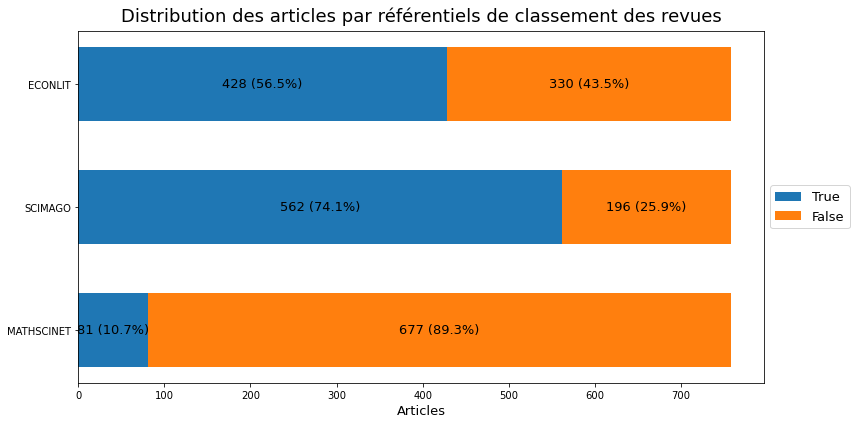

/tmp/ipykernel_560/2134209590.py:6: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  LOGGER.warn('Skip plotting HCERES as "HCERES_RANK" is not a column of the DataFrame')
[2023-04-02 17:17:51][WARNING][hceres_ranking_plot#6] Skip plotting HCERES as "HCERES_RANK" is not a column of the DataFrame
[2023-04-02 17:17:51][INFO ][cross_referentials_plot#27] Saved figure at "./exports/rankings_distribution_of_articles_in_journal_classification_referentials.png"


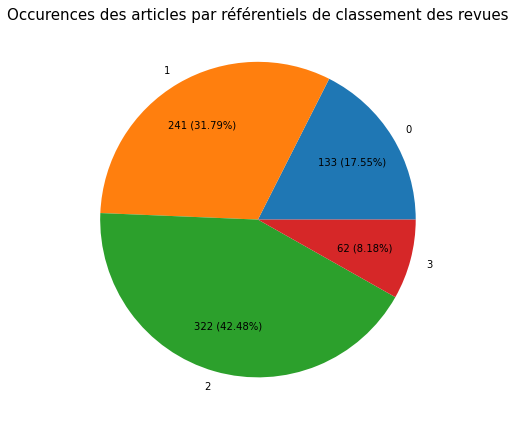

/tmp/ipykernel_560/231509950.py:4: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  LOGGER.warn('Cannot create a matrix for HCERES*Scimago Best Quartile as current dataframe doesn\'t have the columns')
[2023-04-02 17:17:51][WARNING][scimago_hceres_matrix#4] Cannot create a matrix for HCERES*Scimago Best Quartile as current dataframe doesn't have the columns
[2023-04-02 17:17:51][INFO ][scimago_rankings#8] Process scimago rankings (filename_prefix=rankings, titles={'Scimago JCR: categories': 'Distribution des articles par categories Scimago', 'Scimago JCR: quartiles': 'Distribution des articles par quartiles Scimago'})
[2023-04-02 17:17:51][INFO ][create_scimajo_df#19] Saved CSV at "./exports/rankings_scimago.csv"
[2023-04-02 17:17:51][INFO ][create_scimajo_df#23] Rework dataframe to group the less used categories (quantile=0.600000)
[2023-04-02 17:17:51][INFO ][create_scimajo_df#31] Saved CSV at "./exports/rankings_scimago_filtered_0.csv
[2023-04-02 17:17:52

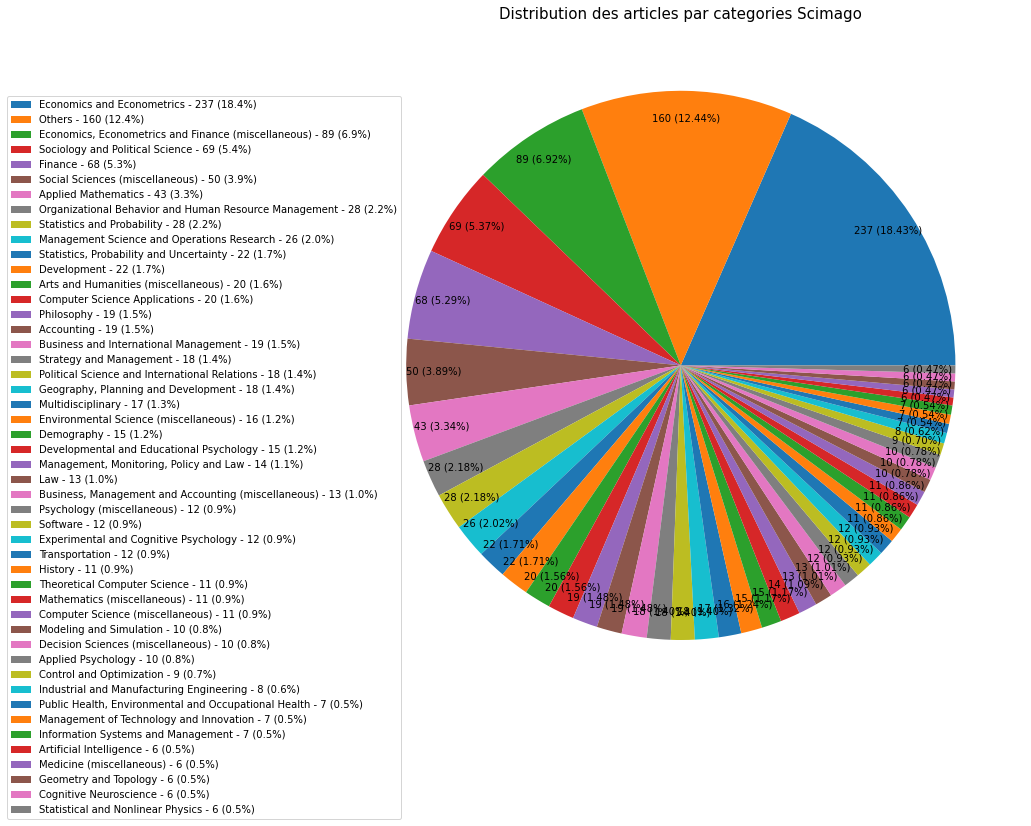

[2023-04-02 17:17:53][INFO ][scimago_ranking_plot#64] Saved figure at "./exports/rankings_scimago_sjr_q_score_0.png"


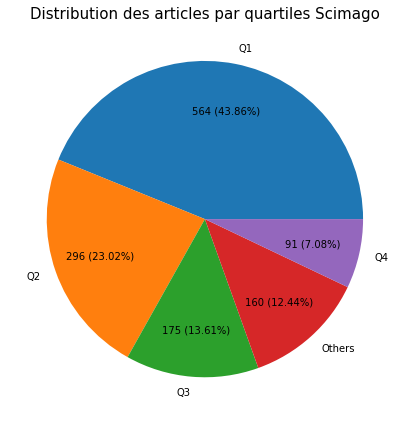

,uri_s,journalTitle_s,journalIssn_s,URL,ECONLIT,MATHSCINET,SCIMAGO_CATEGORIES,SJR_BEST_QUARTILE,SCIMAGO,NUMBER_OF_REFERENTIALS
0,https://shs.hal.science/halshs-01480525,Experimental Economics,1386-4157,https://link.springer.com/journal/volumesAndIs...,True,False,"Economics, Econometrics and Finance (miscellan...",Q1,True,2
1,https://hal.science/hal-01416567,The World Economy,0378-5920,https://onlinelibrary.wiley.com/loi/14679701,True,False,Finance (Q1); Political Science and Internatio...,Q1,True,2
2,https://hal.science/hal-04046263,Maritime Economics and Logistics,1479-2931,https://link.springer.com/journal/volumesAndIs...,True,False,"Economics, Econometrics and Finance (miscellan...",Q1,True,2
3,https://hal-insu.archives-ouvertes.fr/insu-019...,Energy Economics,0140-9883,http://www.sciencedirect.com/science/journal/0...,True,False,Economics and Econometrics (Q1); Energy (misce...,Q1,True,2
4,https://hal.science/hal-02878049,Journal of Mathematical Economics,0304-4068,http://www.sciencedirect.com/science/journal/0...,True,True,Applied Mathematics (Q2); Economics and Econom...,Q2,True,3
...,...,...,...,...,...,...,...,...,...,...
753,https://hal.univ-lille.fr/hal-03367431,Revue de l'OFCE,1265-9576,https://www.cairn.info/revue-de-l-ofce.htm,True,False,"Economics, Econometrics and Finance (miscellan...",Q4,True,2
754,https://shs.hal.science/halshs-01321452,Revue Economique,0035-2764,https://www.cairn.info/revue-economique.htm,True,False,"Economics, Econometrics and Finance (miscellan...",Q3,True,2
755,https://hal.science/hal-01744554,Revue d'économie financière,0987-3368,https://www.cairn.info/revue-d-economie-financ...,True,False,NaN,NaN,False,1
756,https://hal.inrae.fr/hal-03403887,European Economic Review,0014-2921,http://www.sciencedirect.com/science/journal/0...,True,False,Economics and Econometrics (Q1); Finance (Q1),Q1,True,2


In [62]:
ranking_df = rankings(
    dataframe = df_art,
    excludes = ['HCERES'],
    titles = {
        'Articles ranking': 'Distribution des articles par référentiels de classement des revues',
        'HCERES articles ranking': 'Distribution des articles pour le classement HCERES (2021)',
        'Distribution of articles': 'Occurences des articles par référentiels de classement des revues',
    }
)
scimago_hceres_matrix(dataframe=ranking_df)
scimago_rankings(
    dataframe=ranking_df,
    quantile=0.6,
    titles={
        'Scimago JCR: categories': 'Distribution des articles par categories Scimago',
        'Scimago JCR: quartiles':  'Distribution des articles par quartiles Scimago',
    }
)
ranking_df

## Peer reviewing

[2023-04-02 17:17:53][INFO ][csv#35] Export to CSV file: ./exports/articles-peer-reviewing.csv (params: {'index': True, 'sep': ';'}) (number of rows: 2)
[2023-04-02 17:17:53][INFO ][pie#129] Export pie graph to PNG file: ./exports/discribution_of_articles_with_peer_reviewing.png


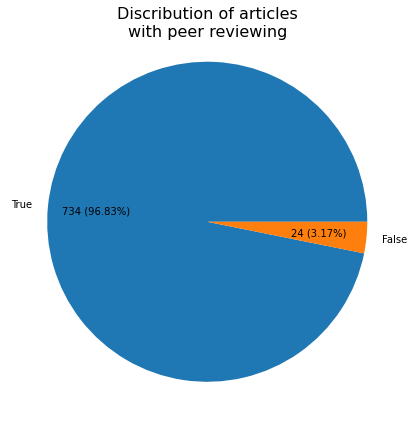

,peerReviewing_s,count
0,True,734
1,False,24


In [63]:
peer_reviewing = df_art[['uri_s', 'peerReviewing_s']].fillna(0).astype({'peerReviewing_s': 'int'})
peer_reviewing['peerReviewing_s'] = peer_reviewing.apply(func=lambda r: r['peerReviewing_s'] == 1, axis='columns')
DfOps(peer_reviewing) \
    .count(subset=['peerReviewing_s'], column='count') \
    .csv('articles-peer-reviewing.csv') \
    .pie(
        column='count',
        label_column='peerReviewing_s',
        title='Discribution of articles\nwith peer reviewing',
        plot_params=dict(figsize=(6,6), pctdistance=0.7),
        sort_params=dict(ascending=False)
    )

# Custom CES

## Producers on any kind of document

In [64]:
df_producers = df.explode(['authLastName_s', 'authFirstName_s', 'authFullName_s']).merge(
    extra_struct_authors,
    how='inner',
    on=['authLastName_s', 'authFirstName_s', 'authFullName_s'],
)
df_producers = df_producers[['authLastName_s', 'authFirstName_s', 'authFullName_s', 'uri_s', 'POSTE']]
df_producers = df_producers.drop_duplicates(ignore_index=True)
DfOps(df_producers).count(subset=['POSTE'], column='count')

,POSTE,count
0,PERMANENTS,1173
1,DOCTORANTS,416
2,EMERITES,304
3,ASSOCIES ET AUTRES,102


## Producers on articles

In [65]:
df_producers = df[df['docType_s'] == 'ART'].explode(['authLastName_s', 'authFirstName_s', 'authFullName_s']).merge(
    extra_struct_authors,
    how='inner',
    on=['authLastName_s', 'authFirstName_s', 'authFullName_s'],
)
df_producers = df_producers[['authLastName_s', 'authFirstName_s', 'authFullName_s', 'uri_s', 'POSTE']]
df_producers = df_producers.drop_duplicates(ignore_index=True)
DfOps(df_producers).count(subset=['POSTE'], column='count')

,POSTE,count
0,PERMANENTS,621
1,DOCTORANTS,148
2,EMERITES,135
3,ASSOCIES ET AUTRES,46


## Nombre d'articles ayant au moins un permanent comme auteurs

[2023-04-02 17:17:53][INFO ][pie#129] Export pie graph to PNG file: ./exports/nombre_d_articles_ayant_au_moins_un_membre_permanent_comme_auteur.png


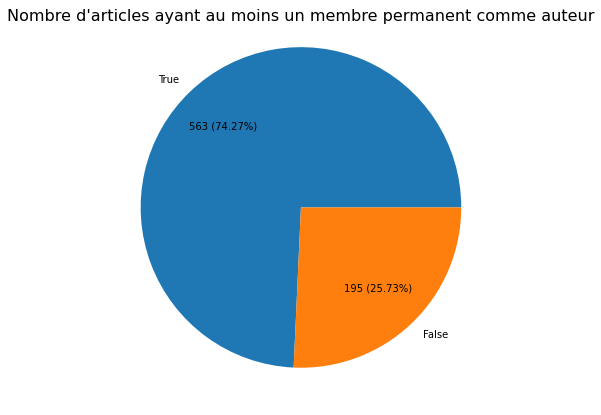

,IS_PERMANENT,count
0,True,563
1,False,195


In [66]:
permanent_articles = df[df['docType_s'] == 'ART'].explode(['authLastName_s', 'authFirstName_s', 'authFullName_s']).merge(
    extra_struct_authors,
    how='inner',
    on=['authLastName_s', 'authFirstName_s', 'authFullName_s'],
)
permanent_articles = permanent_articles[['authLastName_s', 'authFirstName_s', 'authFullName_s', 'uri_s', 'POSTE']]
permanent_articles['IS_PERMANENT'] = permanent_articles.apply(func=lambda r: r['POSTE'] == 'PERMANENTS', axis='columns')
permanent_articles = permanent_articles[['uri_s', 'IS_PERMANENT']]

permanent_articles = permanent_articles.groupby(by=['uri_s']).agg({ 'IS_PERMANENT': lambda r: r.any() })

DfOps(permanent_articles) \
    .count(subset=['IS_PERMANENT'], column='count') \
    .pie(
        column='count',
        label_column='IS_PERMANENT',
        title='Nombre d\'articles ayant au moins un membre permanent comme auteur',
        plot_params=dict(figsize=(6, 6), pctdistance=0.7),
        sort_params=dict(ascending=False),
    )

## Number of articles with peer reviewing comitee produces by permanent

[2023-04-02 17:17:53][INFO ][pie#129] Export pie graph to PNG file: ./exports/nombre_d_articles_comit_de_lecture_produits_par_les_permanents.png


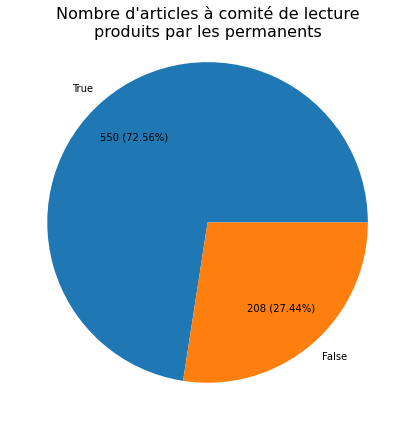

,PRODUCE_BY_PERMANENT_WITH_PEER_REVIEWING,count
0,True,550
1,False,208


In [67]:
permanent_peer_reviewing_articles = df[['uri_s', 'docType_s', 'peerReviewing_s', 'authLastName_s', 'authFirstName_s', 'authFullName_s']]

# Filter on articles
permanent_peer_reviewing_articles = permanent_peer_reviewing_articles[permanent_peer_reviewing_articles['docType_s'] == 'ART']
permanent_peer_reviewing_articles['peerReviewing_s'] = permanent_peer_reviewing_articles['peerReviewing_s'].fillna(0).astype('int')
permanent_peer_reviewing_articles = permanent_peer_reviewing_articles.drop(columns=['docType_s'])

# Explode authors to merge it with extra_struct_authors
permanent_peer_reviewing_articles = permanent_peer_reviewing_articles.explode(['authLastName_s', 'authFirstName_s', 'authFullName_s']).merge(
    extra_struct_authors,
    how='left',
    on=['authLastName_s', 'authFirstName_s', 'authFullName_s']
)

# Reject all POSTE that are not defined (not in CES)
permanent_peer_reviewing_articles = permanent_peer_reviewing_articles[permanent_peer_reviewing_articles['POSTE'].notnull()].reset_index(drop=True)

permanent_peer_reviewing_articles['PRODUCE_BY_PERMANENT_WITH_PEER_REVIEWING'] = permanent_peer_reviewing_articles.apply(
    func=lambda r: r['peerReviewing_s'] if r['POSTE'] == 'PERMANENTS' else 0,
    axis='columns'
)

permanent_peer_reviewing_articles = permanent_peer_reviewing_articles[['uri_s', 'PRODUCE_BY_PERMANENT_WITH_PEER_REVIEWING']]

#permanent_peer_reviewing_articles
permanent_peer_reviewing_articles = permanent_peer_reviewing_articles.groupby(by=['uri_s']).agg({ 'PRODUCE_BY_PERMANENT_WITH_PEER_REVIEWING': lambda r: r.sum() > 0 })

DfOps(permanent_peer_reviewing_articles) \
    .count(subset=['PRODUCE_BY_PERMANENT_WITH_PEER_REVIEWING'], column='count') \
    .pie(
        column='count',
        label_column='PRODUCE_BY_PERMANENT_WITH_PEER_REVIEWING',
        title='Nombre d\'articles à comité de lecture\nproduits par les permanents',
        plot_params=dict(figsize=(6, 6), pctdistance=0.7),
        sort_params=dict(ascending=False),
    )

## Number of articles of Ranking A HCERES produces by permanent

[2023-04-02 17:17:53][INFO ][create_ranking_journals_df#6] Create ranking dataframe including: ['HCERES'] (excludes=['ECONLIT', 'MATHSCINET', 'SCIMAGO'])
[2023-04-02 17:17:53][INFO ][pie#129] Export pie graph to PNG file: ./exports/articles_de_rang_a_classement_hceres_vague_b_2021_produits_par_les_permanents.png


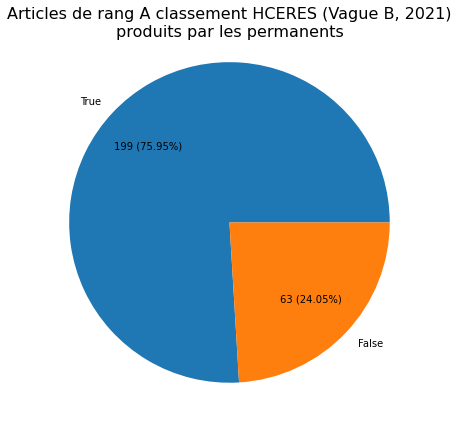

,BY_PERMANENT,count
0,True,199
1,False,63


In [68]:
# Create dataframe with HCERES Ranking
permanent_rank_a_hceres_articles = create_ranking_journals_df(dataframe=df, excludes=['ECONLIT', 'MATHSCINET', 'SCIMAGO'])

# Merge with original DataFrame and filter on articles
permanent_rank_a_hceres_articles = permanent_rank_a_hceres_articles.merge(df, how='left', on=['uri_s'])
permanent_rank_a_hceres_articles = permanent_rank_a_hceres_articles[permanent_rank_a_hceres_articles['docType_s'] == 'ART']

# Keep required columns
permanent_rank_a_hceres_articles = permanent_rank_a_hceres_articles[['uri_s', 'HCERES_RANK', 'authLastName_s', 'authFirstName_s', 'authFullName_s']]

# Explode authors to merge it with extra_struct_authors
permanent_rank_a_hceres_articles = permanent_rank_a_hceres_articles.explode(['authLastName_s', 'authFirstName_s', 'authFullName_s']).merge(
    extra_struct_authors,
    how='left',
    on=['authLastName_s', 'authFirstName_s', 'authFullName_s']
)

# Drop POSTE having null => not in CES
permanent_rank_a_hceres_articles = permanent_rank_a_hceres_articles[permanent_rank_a_hceres_articles['POSTE'].notnull()]

# Keep required columns and create new columns for RANK_A By PERMANENT
permanent_rank_a_hceres_articles = permanent_rank_a_hceres_articles[['uri_s', 'HCERES_RANK', 'POSTE']]

# Filter only on article with A ranking in HCERES System
permanent_rank_a_hceres_articles = permanent_rank_a_hceres_articles[permanent_rank_a_hceres_articles['HCERES_RANK'] == 'A']

# Create a new columns to identify permanent
permanent_rank_a_hceres_articles['BY_PERMANENT'] = permanent_rank_a_hceres_articles.apply(func=lambda r: r['POSTE'] == 'PERMANENTS', axis='columns')

# Drop columns, group by uri and aggregate
permanent_rank_a_hceres_articles = permanent_rank_a_hceres_articles \
    .drop(columns=['HCERES_RANK', 'POSTE']) \
    .groupby(by=['uri_s']) \
    .agg({'BY_PERMANENT': lambda r: r.any() }).reset_index()

DfOps(permanent_rank_a_hceres_articles) \
    .count(subset=['BY_PERMANENT'], column='count') \
    .pie(
        column='count',
        label_column='BY_PERMANENT',
        title='Articles de rang A classement HCERES (Vague B, 2021)\nproduits par les permanents',
        plot_params=dict(figsize=(6, 6), pctdistance=0.7),
        sort_params=dict(ascending=False),
    )

## Pourcentage de permanents sans articles a comité de lecture

,uri_s,docType_s,peerReviewing_s,POSTE,LASTNAME,FIRSTNAME
0,https://shs.hal.science/halshs-01480525,ART,1,PERMANENTS,JACQUEMET,Nicolas
1,https://hal.science/hal-02866828,ART,1,PERMANENTS,JACQUEMET,Nicolas
2,https://shs.hal.science/halshs-01971468,ART,1,PERMANENTS,JACQUEMET,Nicolas
3,https://shs.hal.science/halshs-01476515,ART,1,PERMANENTS,JACQUEMET,Nicolas
4,https://shs.hal.science/halshs-03277342,ART,1,PERMANENTS,JACQUEMET,Nicolas
...,...,...,...,...,...,...
692,0,0,0,PERMANENTS,SALOGNON,Marie
693,0,0,0,PERMANENTS,TOURE,Nouhoum
694,0,0,0,PERMANENTS,VENTURA-KOSKAS,Caroline
695,0,0,0,PERMANENTS,VERDUGO,Grégory


[2023-04-02 17:17:54][INFO ][csv#35] Export to CSV file: ./exports/ces-permanents-without-articles-with-peer-reviewing.csv (params: {'index': False, 'sep': ';'}) (number of rows: 697)
[2023-04-02 17:17:54][INFO ][pie#129] Export pie graph to PNG file: ./exports/nombre_de_permanents_avec_au_moins_un_article_comit_de_lecture.png


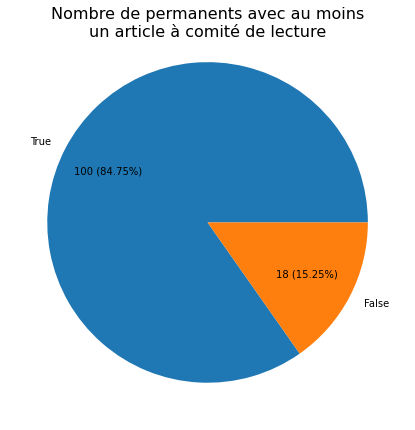

,HAS_ARTICLES_WITH_PEER_REVIEWING,count
0,True,100
1,False,18


In [69]:
# Filter on articles and explode authors
permanent_without_peer_reviewing_articles = df[['uri_s', 'docType_s', 'peerReviewing_s', 'authLastName_s', 'authFirstName_s', 'authFullName_s']]
permanent_without_peer_reviewing_articles = permanent_without_peer_reviewing_articles[permanent_without_peer_reviewing_articles['docType_s'] == 'ART']
permanent_without_peer_reviewing_articles = permanent_without_peer_reviewing_articles.explode(['authLastName_s', 'authFirstName_s', 'authFullName_s'])

# Merge with extra struct authors
permanent_without_peer_reviewing_articles = permanent_without_peer_reviewing_articles.merge(
    extra_struct_authors,
    how='outer',
    on=['authLastName_s', 'authFirstName_s', 'authFullName_s']
)

# Filter on permanents
permanent_without_peer_reviewing_articles = permanent_without_peer_reviewing_articles[permanent_without_peer_reviewing_articles['POSTE'] == 'PERMANENTS']
permanent_without_peer_reviewing_articles = permanent_without_peer_reviewing_articles.drop(columns=['authLastName_s', 'authFirstName_s', 'authFullName_s'])
permanent_without_peer_reviewing_articles = permanent_without_peer_reviewing_articles.reset_index(drop=True)

permanent_without_peer_reviewing_articles = permanent_without_peer_reviewing_articles.fillna(0).astype({'peerReviewing_s': int})
DfOps(permanent_without_peer_reviewing_articles).display().csv('ces-permanents-without-articles-with-peer-reviewing.csv', index=False)

# Group by Lastname + Fistname
permanent_without_peer_reviewing_articles = permanent_without_peer_reviewing_articles.groupby(['LASTNAME', 'FIRSTNAME']) \
    .agg({ 'peerReviewing_s': lambda x: x.dropna().sum() > 0 }) \
    .rename(columns={'peerReviewing_s': 'HAS_ARTICLES_WITH_PEER_REVIEWING'}) \
    .reset_index()

# Count, diagrams and display
DfOps(permanent_without_peer_reviewing_articles) \
    .count(subset=['HAS_ARTICLES_WITH_PEER_REVIEWING'], column='count') \
    .pie(
        column='count',
        label_column='HAS_ARTICLES_WITH_PEER_REVIEWING',
        title='Nombre de permanents avec au moins\nun article à comité de lecture',
        plot_params=dict(pctdistance=0.7, figsize=(6, 6), ),
        sort_params=dict(ascending=False)
    )

## Nombre de travaux par permanents (pourcentage)

[2023-04-02 17:17:54][INFO ][csv#35] Export to CSV file: ./exports/ces-number-of-work-by-permanent.csv (params: {'index': False, 'sep': ';'}) (number of rows: 118)
[2023-04-02 17:17:54][INFO ][pie#129] Export pie graph to PNG file: ./exports/distribution_du_nombre_de_travaux_par_permanents.png


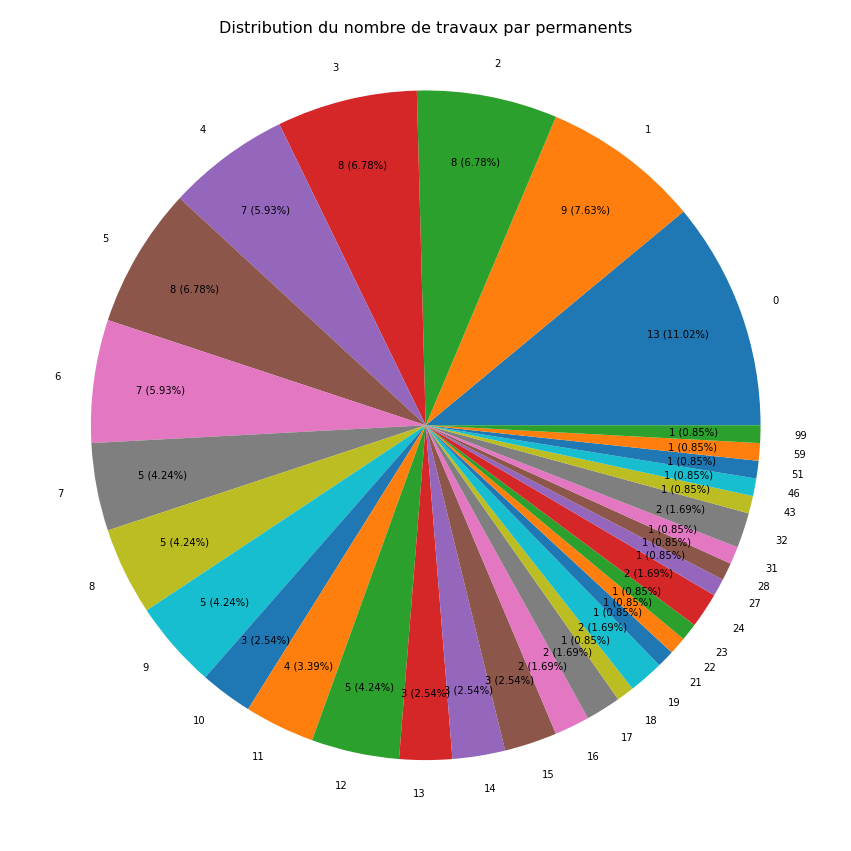

,NUMBER_OF_WORKS,count
0,0,13
1,1,9
2,2,8
3,3,8
5,4,7
4,5,8
6,6,7
10,7,5
9,8,5
8,9,5


In [70]:
permanent_number_of_works = df[['uri_s', 'authLastName_s', 'authFirstName_s', 'authFullName_s']]

# Merge with extra struct authors
permanent_number_of_works = permanent_number_of_works.explode(['authLastName_s', 'authFirstName_s', 'authFullName_s']).merge(
    extra_struct_authors,
    how='outer',
    on=['authLastName_s', 'authFirstName_s', 'authFullName_s']
)

permanent_number_of_works = permanent_number_of_works[permanent_number_of_works['POSTE'] == 'PERMANENTS'].reset_index(drop=True)
permanent_number_of_works = permanent_number_of_works.drop(columns=['authLastName_s', 'authFirstName_s', 'authFullName_s'])

permanent_number_of_works['NUMBER_OF_WORKS'] = permanent_number_of_works.apply(func=lambda r: 1 if pd.notnull(r['uri_s']) else 0, axis='columns')

# Keep only required columns, group by FIRSTNAME & LASTNAME and sum
permanent_number_of_works = permanent_number_of_works.drop(columns=['uri_s', 'POSTE']).groupby(by=['LASTNAME', 'FIRSTNAME']).sum().reset_index()

permanent_number_of_works = permanent_number_of_works.sort_values(by=['NUMBER_OF_WORKS'])

DfOps(permanent_number_of_works) \
    .csv('ces-number-of-work-by-permanent.csv', index=False) \
    .count(subset=['NUMBER_OF_WORKS'], column='count') \
    .pie(
        column='count',
        label_column='NUMBER_OF_WORKS',
        title='Distribution du nombre de travaux par permanents',
        sort_by='NUMBER_OF_WORKS',
        title_params={'y': 1.0, 'pad': -26}
    )

[2023-04-02 17:17:54][INFO ][pie#129] Export pie graph to PNG file: ./exports/nombre_de_travaux_par_permanents.png


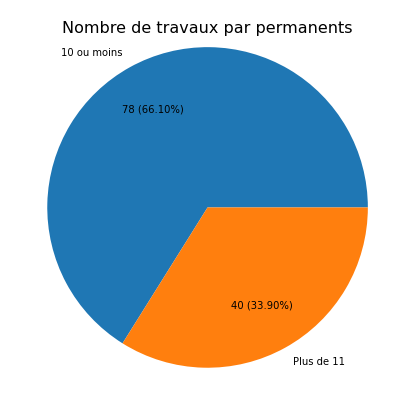

,NUMBER_OF_WORKS_CAT,count
0,10 ou moins,78
1,Plus de 11,40


In [71]:
permanent_number_of_works['NUMBER_OF_WORKS_CAT'] = permanent_number_of_works['NUMBER_OF_WORKS'].apply(
    lambda x: '10 ou moins' if x <= 10 else 'Plus de 11'
)
DfOps(permanent_number_of_works) \
    .count(subset=['NUMBER_OF_WORKS_CAT'], column='count') \
    .pie(
        column='count',
        label_column='NUMBER_OF_WORKS_CAT',
        title='Nombre de travaux par permanents',
        sort_by='NUMBER_OF_WORKS_CAT',
        title_params={'y': 1.0, 'pad': -26},
        plot_params=dict(figsize=(6, 6), pctdistance=0.7),
    )

## Nombre d'articles par permanents (pourcentage)

[2023-04-02 17:17:54][INFO ][csv#35] Export to CSV file: ./exports/ces-number-of-articles-by-permanent.csv (params: {'index': False, 'sep': ';'}) (number of rows: 118)
[2023-04-02 17:17:55][INFO ][pie#129] Export pie graph to PNG file: ./exports/distribution_du_nombre_d_articles_par_permanents.png


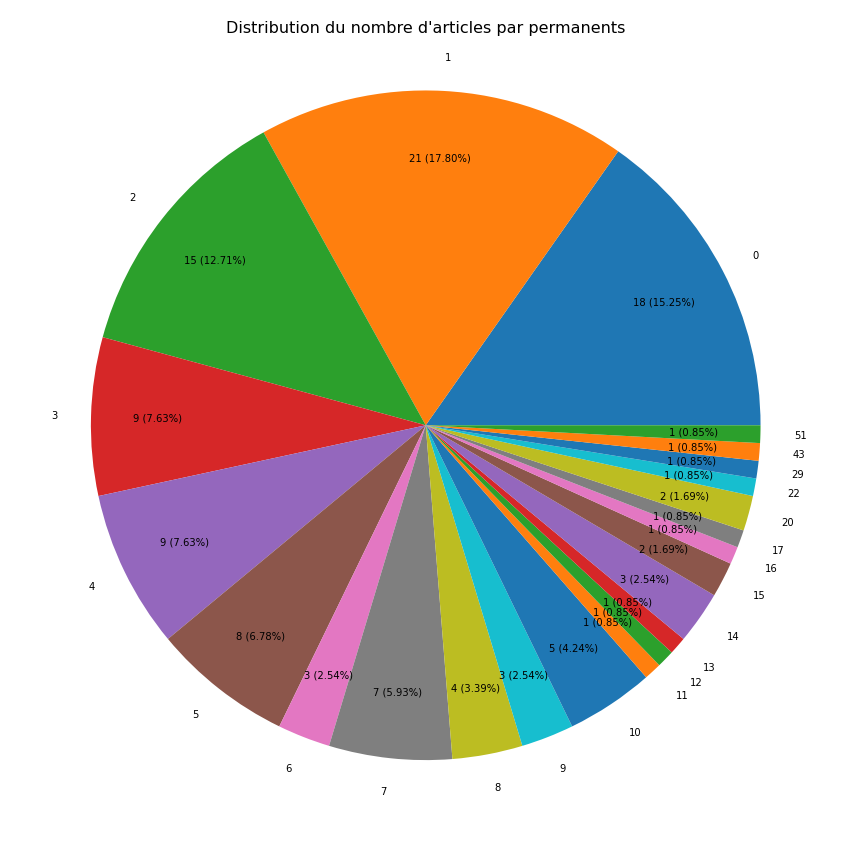

,NUMBER_OF_WORKS,count
1,0,18
0,1,21
2,2,15
3,3,9
4,4,9
5,5,8
10,6,3
6,7,7
8,8,4
9,9,3


In [72]:
permanent_number_of_articles = df[df['docType_s'] == 'ART']
permanent_number_of_articles = permanent_number_of_articles[['uri_s', 'authLastName_s', 'authFirstName_s', 'authFullName_s']]

# Merge with extra struct authors
permanent_number_of_articles = permanent_number_of_articles.explode(['authLastName_s', 'authFirstName_s', 'authFullName_s']).merge(
    extra_struct_authors,
    how='outer',
    on=['authLastName_s', 'authFirstName_s', 'authFullName_s']
)

permanent_number_of_articles = permanent_number_of_articles[permanent_number_of_articles['POSTE'] == 'PERMANENTS'].reset_index(drop=True)
permanent_number_of_articles = permanent_number_of_articles.drop(columns=['authLastName_s', 'authFirstName_s', 'authFullName_s'])

permanent_number_of_articles['NUMBER_OF_WORKS'] = permanent_number_of_articles.apply(func=lambda r: 1 if pd.notnull(r['uri_s']) else 0, axis='columns')

# Keep only required columns, group by FIRSTNAME & LASTNAME and sum
permanent_number_of_articles = permanent_number_of_articles.drop(columns=['uri_s', 'POSTE']).groupby(by=['LASTNAME', 'FIRSTNAME']).sum().reset_index()

permanent_number_of_articles = permanent_number_of_articles.sort_values(by=['NUMBER_OF_WORKS'])

DfOps(permanent_number_of_articles) \
    .csv('ces-number-of-articles-by-permanent.csv', index=False) \
    .count(subset=['NUMBER_OF_WORKS'], column='count') \
    .pie(
        column='count',
        label_column='NUMBER_OF_WORKS',
        title='Distribution du nombre d\'articles par permanents',
        sort_by='NUMBER_OF_WORKS',
        title_params={'y': 1.0, 'pad': -26}
    )

[2023-04-02 17:17:55][INFO ][pie#129] Export pie graph to PNG file: ./exports/nombre_d_articles_par_permanents.png


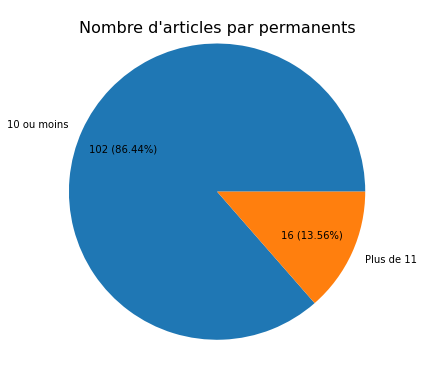

,NUMBER_OF_WORKS_CAT,count
0,10 ou moins,102
1,Plus de 11,16


In [73]:
permanent_number_of_articles['NUMBER_OF_WORKS_CAT'] = permanent_number_of_articles['NUMBER_OF_WORKS'].apply(
    lambda x: '10 ou moins' if x <= 10 else 'Plus de 11'
)
DfOps(permanent_number_of_articles) \
    .count(subset=['NUMBER_OF_WORKS_CAT'], column='count') \
    .pie(
        column='count',
        label_column='NUMBER_OF_WORKS_CAT',
        title='Nombre d\'articles par permanents',
        sort_by='NUMBER_OF_WORKS_CAT',
        title_params={'y': 1.0, 'pad': -26},
        plot_params=dict(figsize=(6, 6), pctdistance=0.7),
    )

## Nombre de monographies par permanents (pourcentage)

[2023-04-02 17:17:55][INFO ][csv#35] Export to CSV file: ./exports/ces-number-of-books-by-permanent.csv (params: {'index': False, 'sep': ';'}) (number of rows: 118)
[2023-04-02 17:17:55][INFO ][pie#129] Export pie graph to PNG file: ./exports/distribution_du_nombre_d_ouvrages_et_chapitres_d_ouvrages_par_permanents.png


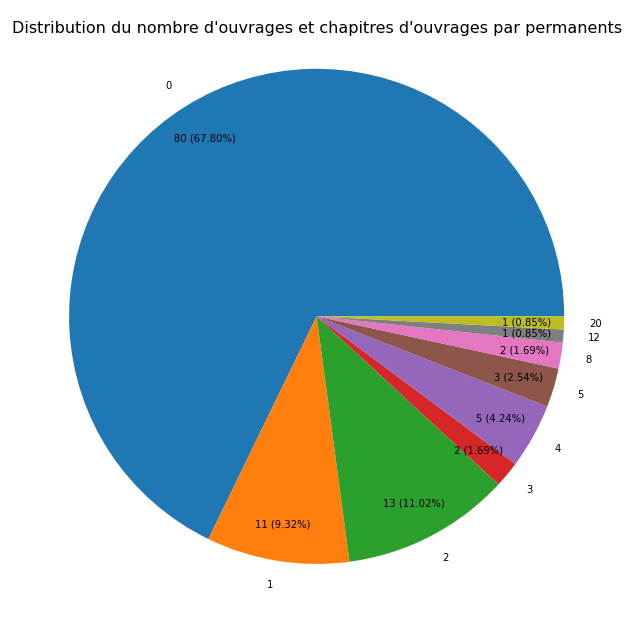

,NUMBER_OF_WORKS,count
0,0,80
2,1,11
1,2,13
5,3,2
3,4,5
4,5,3
6,8,2
7,12,1
8,20,1


In [74]:
permanent_number_of_books = df[df['docType_s'].isin(['OUV', 'COUV'])]
permanent_number_of_books = permanent_number_of_books[['uri_s', 'authLastName_s', 'authFirstName_s', 'authFullName_s']]

# Merge with extra struct authors
permanent_number_of_books = permanent_number_of_books.explode(['authLastName_s', 'authFirstName_s', 'authFullName_s']).merge(
    extra_struct_authors,
    how='outer',
    on=['authLastName_s', 'authFirstName_s', 'authFullName_s']
)

permanent_number_of_books = permanent_number_of_books[permanent_number_of_books['POSTE'] == 'PERMANENTS'].reset_index(drop=True)
permanent_number_of_books = permanent_number_of_books.drop(columns=['authLastName_s', 'authFirstName_s', 'authFullName_s'])

permanent_number_of_books['NUMBER_OF_WORKS'] = permanent_number_of_books.apply(func=lambda r: 1 if pd.notnull(r['uri_s']) else 0, axis='columns')

# Keep only required columns, group by FIRSTNAME & LASTNAME and sum
permanent_number_of_books = permanent_number_of_books.drop(columns=['uri_s', 'POSTE']).groupby(by=['LASTNAME', 'FIRSTNAME']).sum().reset_index()

permanent_number_of_books = permanent_number_of_books.sort_values(by=['NUMBER_OF_WORKS'])

DfOps(permanent_number_of_books) \
    .csv('ces-number-of-books-by-permanent.csv', index=False) \
    .count(subset=['NUMBER_OF_WORKS'], column='count') \
    .pie(
        column='count',
        label_column='NUMBER_OF_WORKS',
        title='Distribution du nombre d\'ouvrages et chapitres d\'ouvrages par permanents',
        sort_by='NUMBER_OF_WORKS',
        title_params={'y': 1.0, 'pad': -26},
        plot_params=dict(figsize=(9, 9), pctdistance=0.85),
    )

[2023-04-02 17:17:55][INFO ][pie#129] Export pie graph to PNG file: ./exports/nombre_d_ouvrages_et_chapitres_d_ouvrages_par_permanents.png


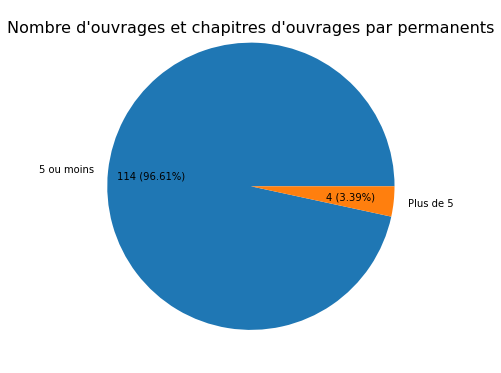

,NUMBER_OF_WORKS_CAT,count
0,5 ou moins,114
1,Plus de 5,4


In [75]:
permanent_number_of_books['NUMBER_OF_WORKS_CAT'] = permanent_number_of_books['NUMBER_OF_WORKS'].apply(
    lambda x: '5 ou moins' if x <= 5 else 'Plus de 5'
)
DfOps(permanent_number_of_books) \
    .count(subset=['NUMBER_OF_WORKS_CAT'], column='count') \
    .pie(
        column='count',
        label_column='NUMBER_OF_WORKS_CAT',
        title='Nombre d\'ouvrages et chapitres d\'ouvrages par permanents',
        sort_by='NUMBER_OF_WORKS_CAT',
        title_params={'y': 1.0, 'pad': -26},
        plot_params=dict(figsize=(6, 6), pctdistance=0.7),
    )